# Classify Wine Quality
## by Georgios Pligoropoulos

In [1]:
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [68]:
# -*- coding: UTF-8 -*-
from __future__ import division#, print_function # Imports from __future__ since we're running Python 2
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, log_loss
from scipy.stats import skew
from scipy.stats import boxcox
from scipy.stats import pearsonr
%matplotlib inline
from matplotlib import rcParams
from imblearn.over_sampling import SMOTE
rcParams['figure.figsize'] = (15, 7)

In [3]:
seed = 160184
random_state = np.random.RandomState(seed=seed)

## Setting up...

In [4]:
def loadDataset(data_path):
    return pd.read_csv(data_path, delimiter = ';', encoding='utf-8')

In [5]:
# Your code goes here
df = loadDataset('winequality-red.csv')
df.shape

(1599, 12)

In [6]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [7]:
print "number of instances:"
len(df)

number of instances:


1599

In [8]:
print "number of attributes:"
len(df.columns)

number of attributes:


12

In [9]:
df.sample(n=5, random_state=random_state)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1165,8.5,0.440,0.50,1.9,0.369,15.0,38.0,0.99634,3.01,1.10,9.4,5
526,7.3,0.365,0.49,2.5,0.088,39.0,106.0,0.99660,3.36,0.78,11.0,5
902,7.4,0.635,0.10,2.4,0.080,16.0,33.0,0.99736,3.58,0.69,10.8,7
1131,5.9,0.190,0.21,1.7,0.045,57.0,135.0,0.99341,3.32,0.44,9.5,5
784,7.1,0.590,0.01,2.5,0.077,20.0,85.0,0.99746,3.55,0.59,9.8,5


### Do we have any missing attributes?

In [10]:
np.sum(df.isnull())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [11]:
assert np.sum(np.sum(df.isnull())) == 0, "if this fails your dataset has now missing attributes"

#### Note
It is good that we have zero missing attributes, so no downsampling or imputation is necessary

# Exploratory Data Analysis

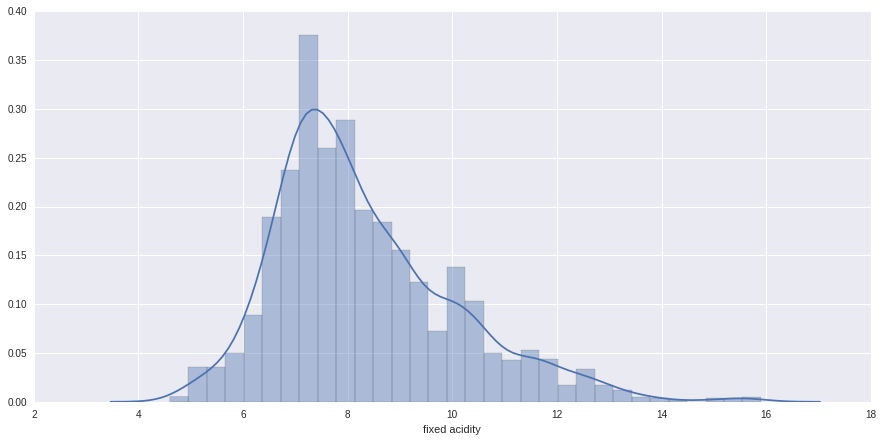

In [12]:
sns.distplot(df['fixed acidity'])
plt.show()

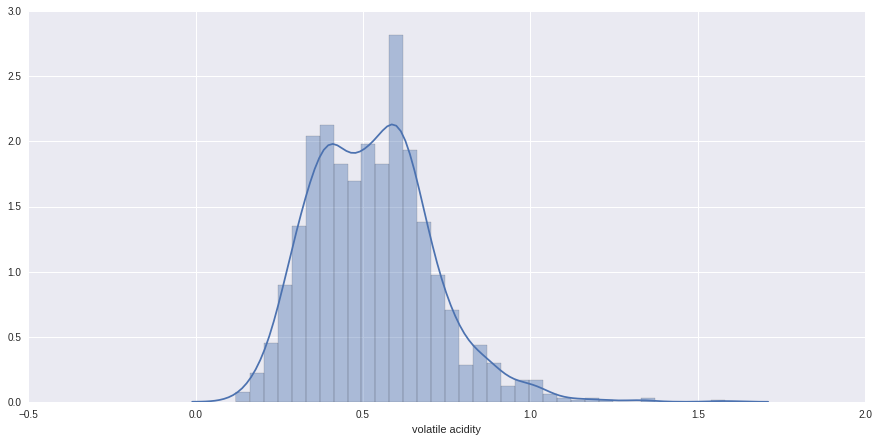

In [13]:
sns.distplot(df['volatile acidity'])
plt.show()

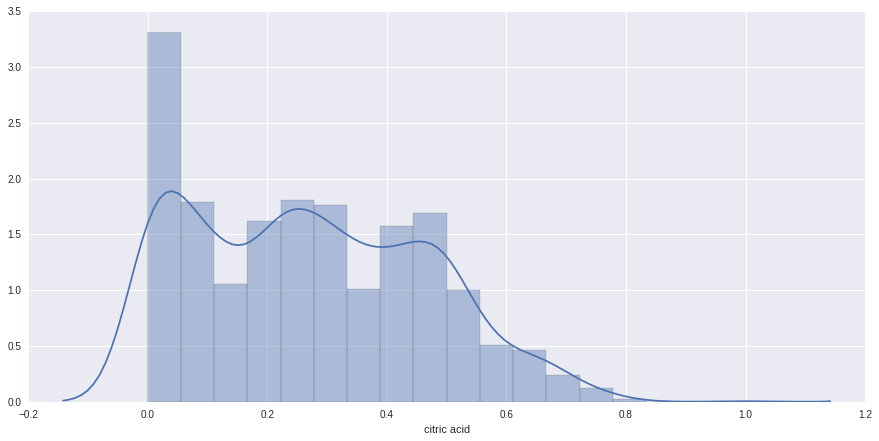

In [14]:
sns.distplot(df['citric acid'])
plt.show()

In [15]:
np.sum(df['citric acid'] == 0)

132

So we observe that citric acid sometimes is completely zero. TODO: should we preprocess it?

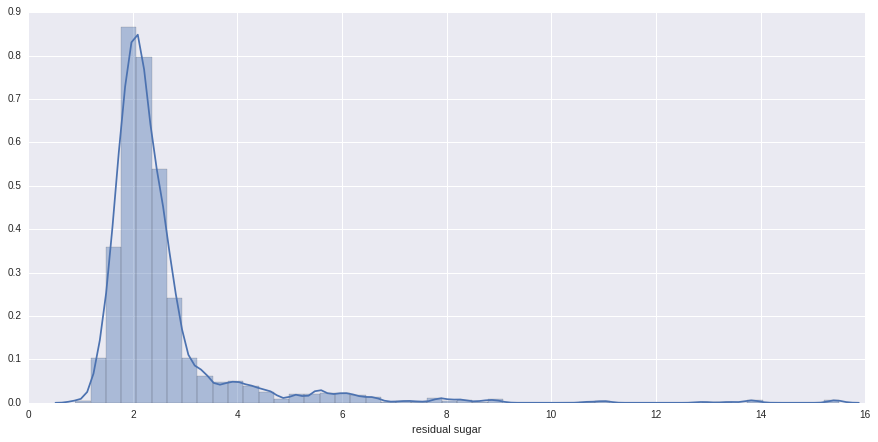

In [16]:
sns.distplot(df['residual sugar'])
plt.show()

In [17]:
skew(df['residual sugar'])

4.536394788805638

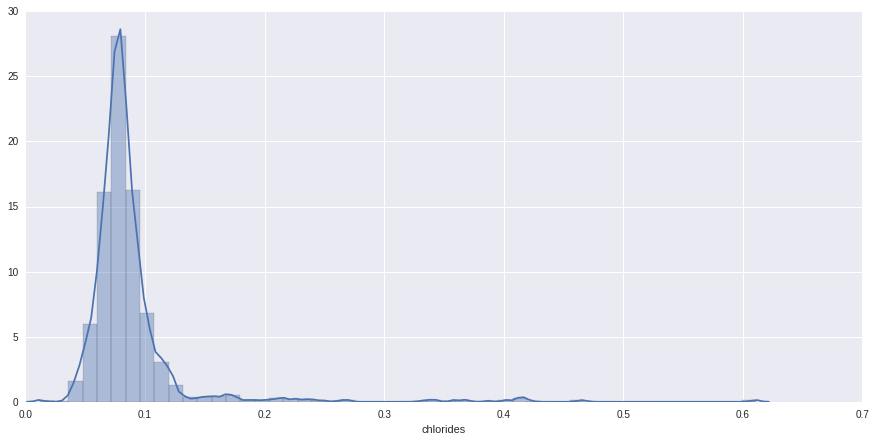

In [18]:
sns.distplot(df['chlorides'])
plt.show()

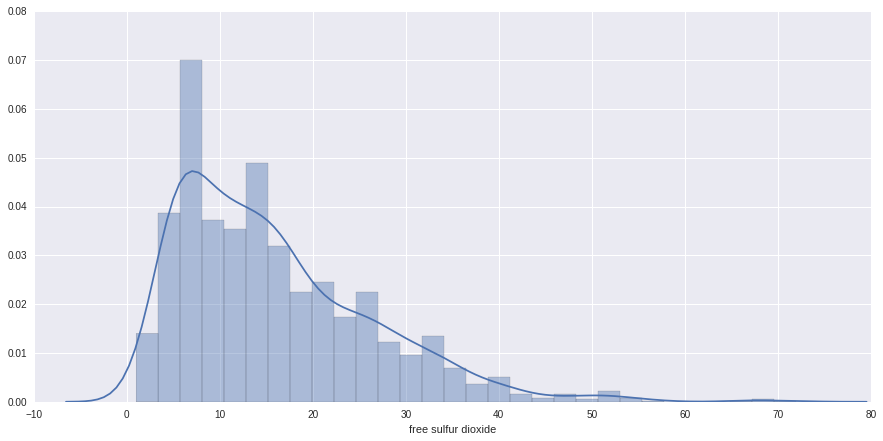

In [19]:
sns.distplot(df['free sulfur dioxide'])
plt.show()

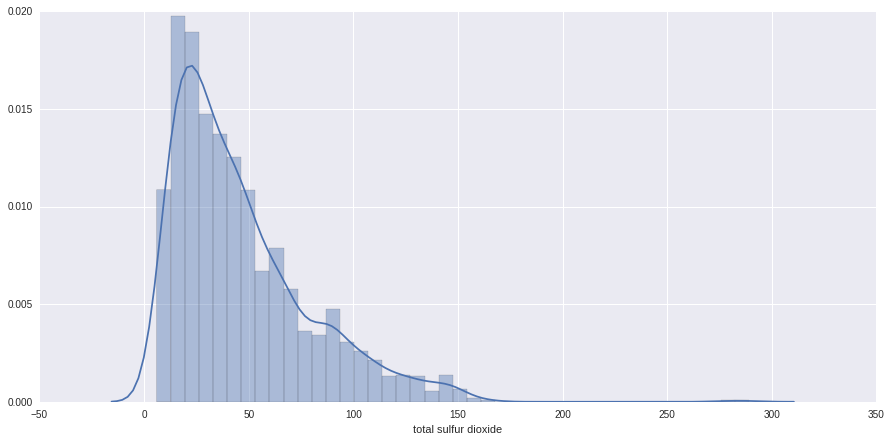

In [20]:
sns.distplot(df['total sulfur dioxide'])
plt.show()

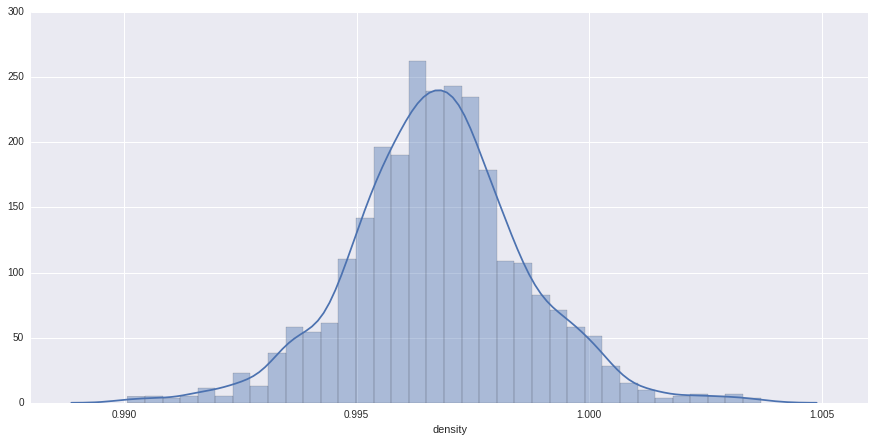

In [21]:
sns.distplot(df['density'])
plt.show()

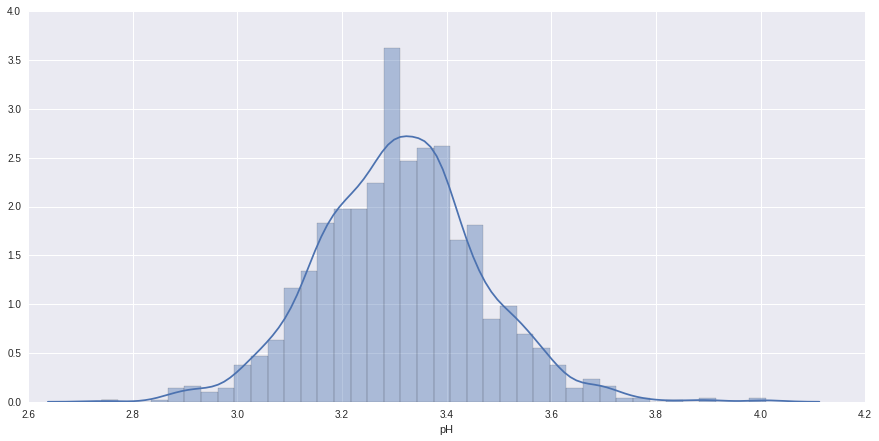

In [22]:
sns.distplot(df['pH'])
plt.show()

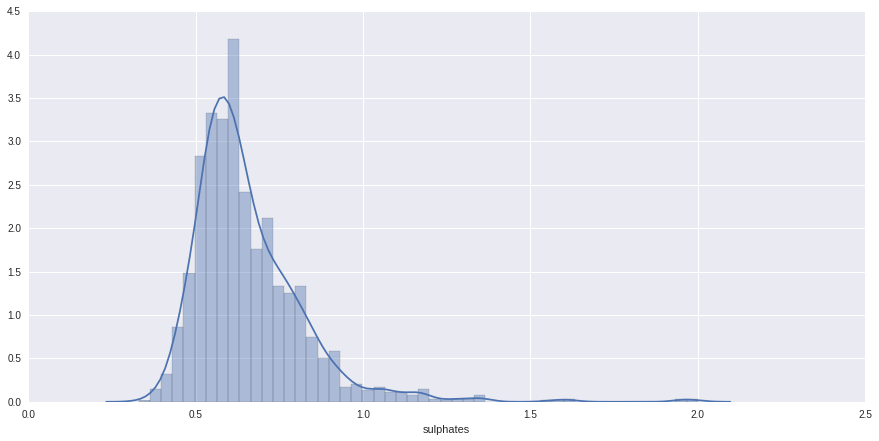

In [23]:
sns.distplot(df['sulphates'])
plt.show()

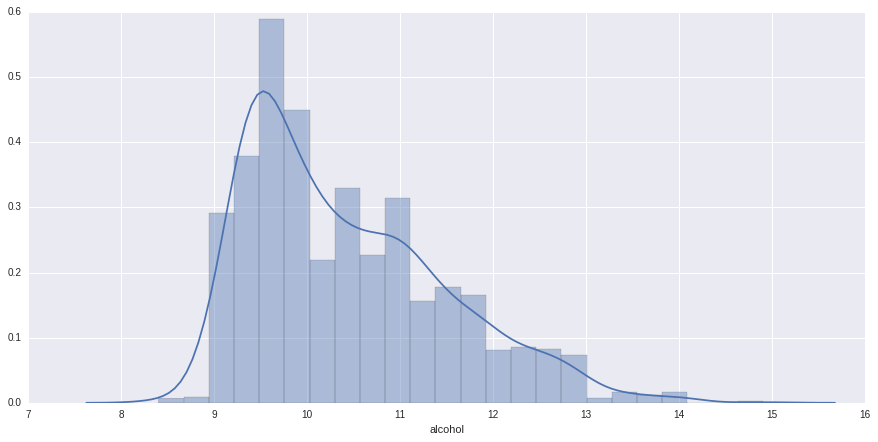

In [24]:
sns.distplot(df['alcohol'])
plt.show()

#### Notes
The conclusions from the above distribution plots is that most of the measurements have only positive values, we observe extreme values on the positive side in many cases and lots of distributions are quite skewed. A log transformation is expected to help most of these cases, except the Citric Acid where we have zero values.  
For Citric Acid we are going to use the transformation log(x + 1) which has the nice property that zero still maps to zero: https://stats.stackexchange.com/questions/1444/how-should-i-transform-non-negative-data-including-zeros

### Apply log transformations for skewed distributions

In [25]:
target_name = 'quality'

In [26]:
XX = df.drop(labels=[target_name], axis=1)
XX.shape

(1599, 11)

In [27]:
from collections import OrderedDict

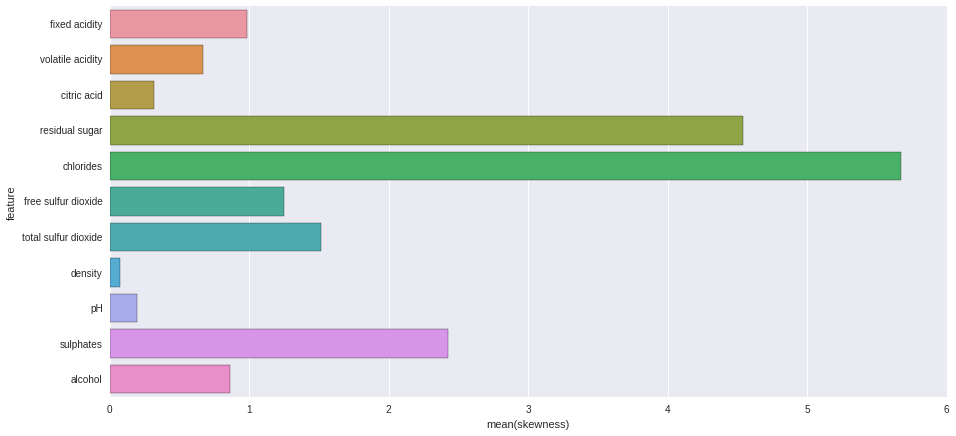

In [28]:
skews = OrderedDict(zip(XX.columns, skew(XX)))
skews = pd.DataFrame({
        'feature': skews.keys(),
        'skewness': skews.values(),
    })
sns.barplot(y='feature', x='skewness', data=skews)
plt.show()

It is obvious that apart density and pH all the rest of the attributes should be tranformed. By default this helps learning in most machine learning models

In [29]:
#MyOutliers.getBoundaries(skews['skewness'])

In [30]:
bounds = np.percentile(skews['skewness'], [10, 90])
bounds

array([ 0.19350176,  4.53639479])

In [31]:
features_to_transform = skews[skews['skewness'] > bounds[0]]['feature']#.values
features_to_transform

0            fixed acidity
1         volatile acidity
2              citric acid
3           residual sugar
4                chlorides
5      free sulfur dioxide
6     total sulfur dioxide
9                sulphates
10                 alcohol
Name: feature, dtype: object

In [32]:
for cur_feat in features_to_transform:
    if cur_feat == 'citric acid':
        XX[cur_feat] += 1
    XX[cur_feat] = np.log(XX[cur_feat])

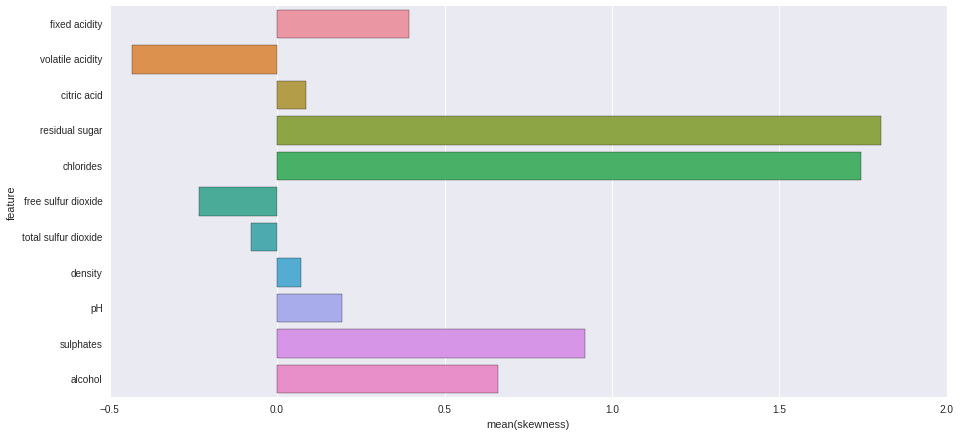

In [33]:
skews = OrderedDict(zip(XX.columns, skew(XX)))
skews = pd.DataFrame({
        'feature': skews.keys(),
        'skewness': skews.values(),
    })
sns.barplot(y='feature', x='skewness', data=skews)
plt.show()

## Outlier detection

In [34]:
from tukey_outliers_helper import TukeyOutliersHelper

In [35]:
bounds = TukeyOutliersHelper().getBoundsFromDataFrame(XX, kk=3.0, outlier_columns=XX.columns)
bounds

fixed acidity             (1.18276868402, 2.99652958408)
volatile acidity         (-2.42757285155, 1.03967720906)
citric acid             (-0.707259829875, 1.14409439773)
residual sugar          (-0.299118790393, 1.89648412159)
chlorides               (-3.41320332178, -1.65400232381)
free sulfur dioxide      (-1.34992671695, 6.34035930373)
total sulfur dioxide    (-0.017233341702, 7.23541018011)
density                              (0.988895, 1.00454)
pH                                          (2.64, 3.97)
sulphates                (-1.4472157685, 0.534668022908)
alcohol                   (1.78433186947, 2.87390503745)
dtype: object

In [36]:
counts = TukeyOutliersHelper.countOutliersDataPoints(XX, bounds)
counts

fixed acidity            0
volatile acidity         0
citric acid              0
residual sugar          32
chlorides               45
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       2
sulphates                4
alcohol                  0
dtype: object

In [37]:
fatal_inds_set = TukeyOutliersHelper.getOutlierDataPoints(XX, bounds)

In [38]:
print "we will be losing {} fraction of the total instances".format(len(fatal_inds_set) / len(XX))

we will be losing 0.0481550969356 fraction of the total instances


In [39]:
keep_inds = list(set(range(len(XX))).difference(fatal_inds_set))
assert len(keep_inds) + len(fatal_inds_set) == len(XX)

In [40]:
XX_no_outliers = XX.iloc[keep_inds]
XX_no_outliers.shape

(1522, 11)

In [41]:
yy = df[target_name]
yy.shape

(1599,)

In [42]:
yy_no_outliers = yy.iloc[keep_inds]
yy_no_outliers.shape

(1522,)

### Side-note
We could also explore Isolation Forest and other similar techniques but it is not of high priority for a first version of our classifier

# Exploring the target
Do we have a balanced/imbalanced dataset? etc.

In [43]:
np.unique(yy_no_outliers)

array([3, 4, 5, 6, 7, 8])

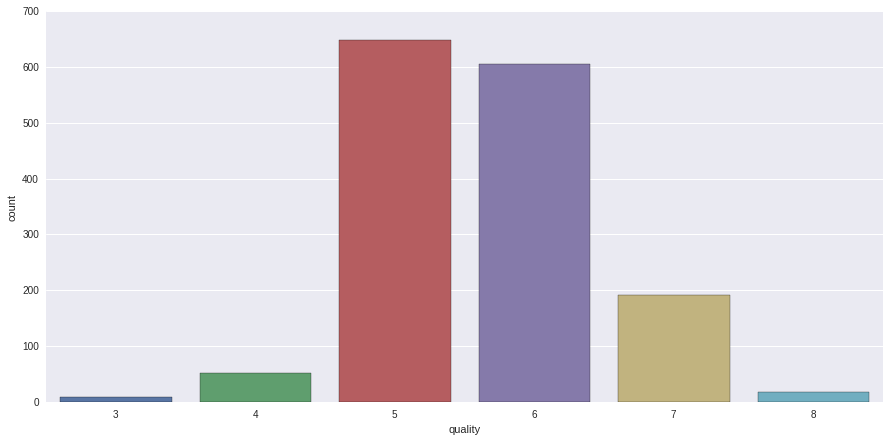

In [44]:
sns.countplot(yy_no_outliers)
plt.show()

### Imbalanced Dataset
We have a highly IMBALANCED dataset  

We also have a small dataset. We cannot downsample!

We need to do proper upsampling:  
http://www.marcoaltini.com/blog/dealing-with-imbalanced-data-undersampling-oversampling-and-proper-cross-validation

First take separate dataset for cross validation and only then do upsampling to train the classifier but validate on this limited dataset

In [45]:
from sklearn.model_selection import StratifiedKFold

In [46]:
n_splits = 10 #by rule of thumb we choose 10 splits

In [47]:
kFold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

In [48]:
data_len = len(XX_no_outliers)
data_len

1522

In [49]:
indices_iterator = kFold.split(np.zeros(data_len),  # this is allowed, check documentation for more info
                                       yy_no_outliers)
for train_inds, valid_inds in indices_iterator:
    #upsample train inds to make them balanced
    #keep valid inds intact
    print train_inds.shape, valid_inds.shape

(1368,) (154,)
(1369,) (153,)
(1369,) (153,)
(1369,) (153,)
(1369,) (153,)
(1369,) (153,)
(1370,) (152,)
(1370,) (152,)
(1373,) (149,)
(1372,) (150,)


/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


smart oversampling using KNN: https://beckernick.github.io/oversampling-modeling/

In [50]:
from imblearn.over_sampling import RandomOverSampler

In [51]:
from imblearn.over_sampling import SMOTE

In [52]:
sm = SMOTE(random_state=random_state)

In [53]:
ros = RandomOverSampler(random_state=random_state)

(3888, 11) (3888,)


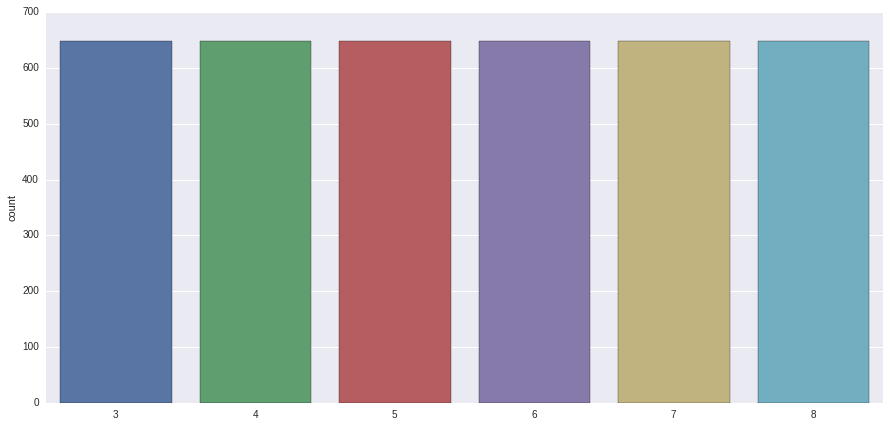

In [55]:
#unit testing
xx_upsampled, yy_upsampled = ros.fit_sample(XX_no_outliers, yy_no_outliers)
print xx_upsampled.shape, yy_upsampled.shape
sns.countplot(yy_upsampled)
plt.show()

Our method provides a balanced dataset

## Exploring Attributes per class

In [56]:
df_clean = pd.concat((XX_no_outliers, yy_no_outliers.to_frame()), axis=1)
df_clean.shape

(1522, 12)

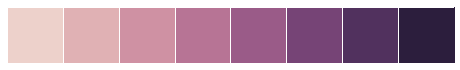

In [57]:
sns.set(font_scale=2.0)
sns.palplot(sns.cubehelix_palette(8)) #https://seaborn.pydata.org/tutorial/color_palettes.html

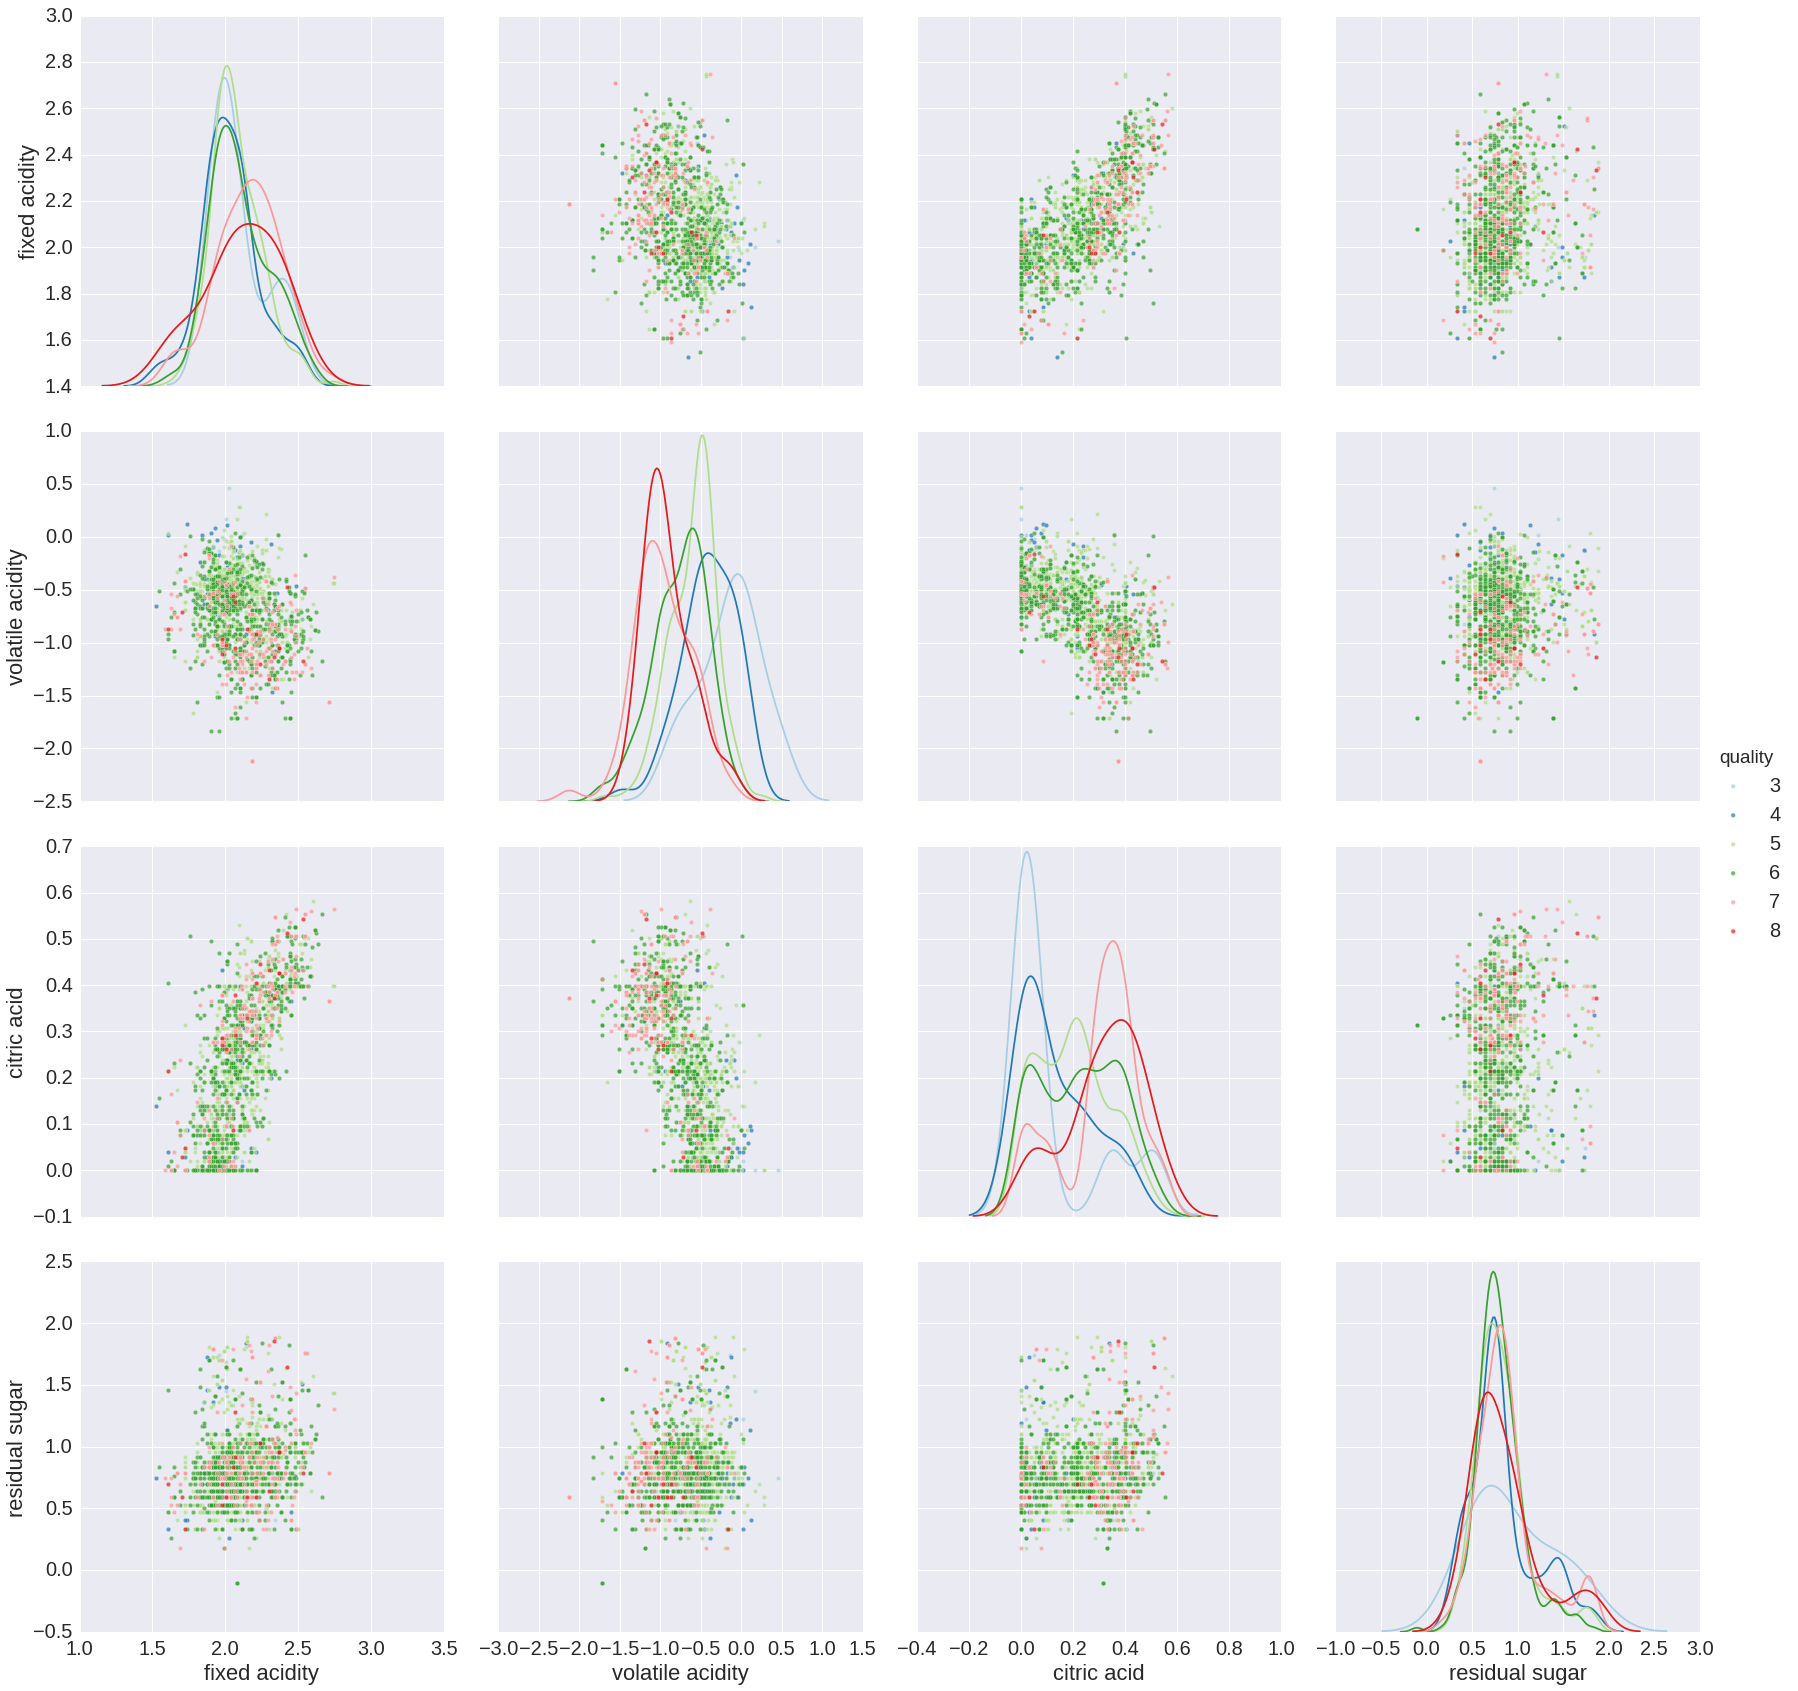

In [58]:
#plt.figure(figsize=(15,7))
sns.pairplot(df_clean, vars = df_clean.columns[:4], hue=target_name, diag_kind='kde',
             palette=sns.color_palette("Paired"), plot_kws={'hold' : True, 'marker': 'o', 'alpha': 0.7},size=6)
plt.show()

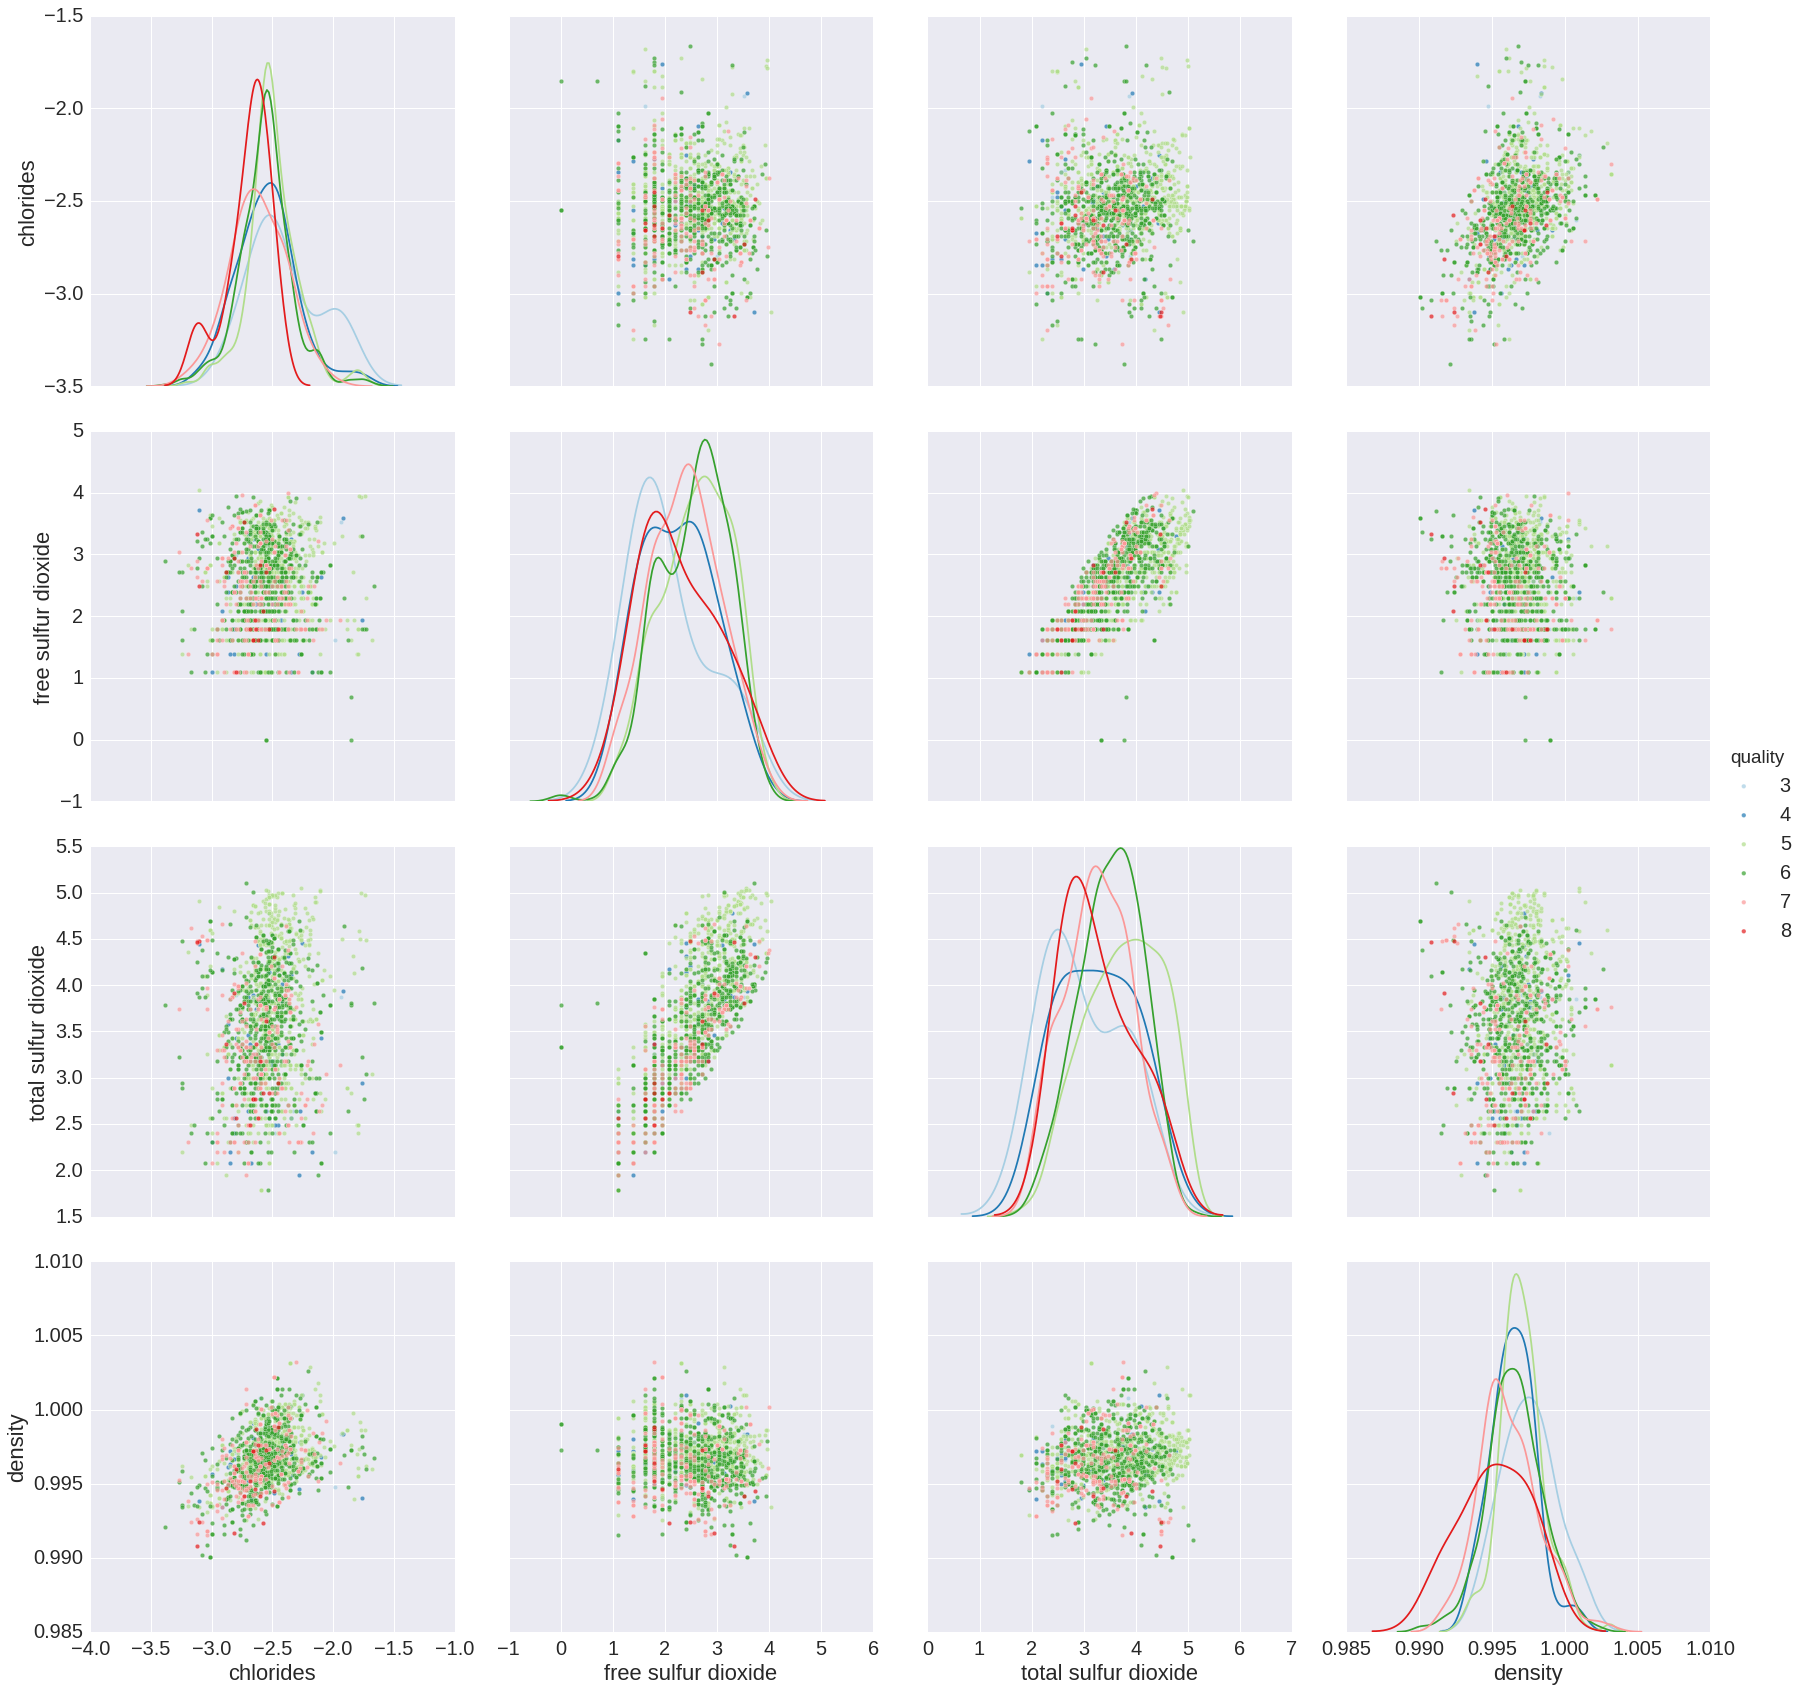

In [59]:
sns.pairplot(df_clean, vars = df_clean.columns[4:8], hue=target_name, diag_kind='kde',\
            palette=sns.color_palette("Paired"), plot_kws={'hold' : True, 'marker': 'o', 'alpha': 0.7},size=6)
plt.show()

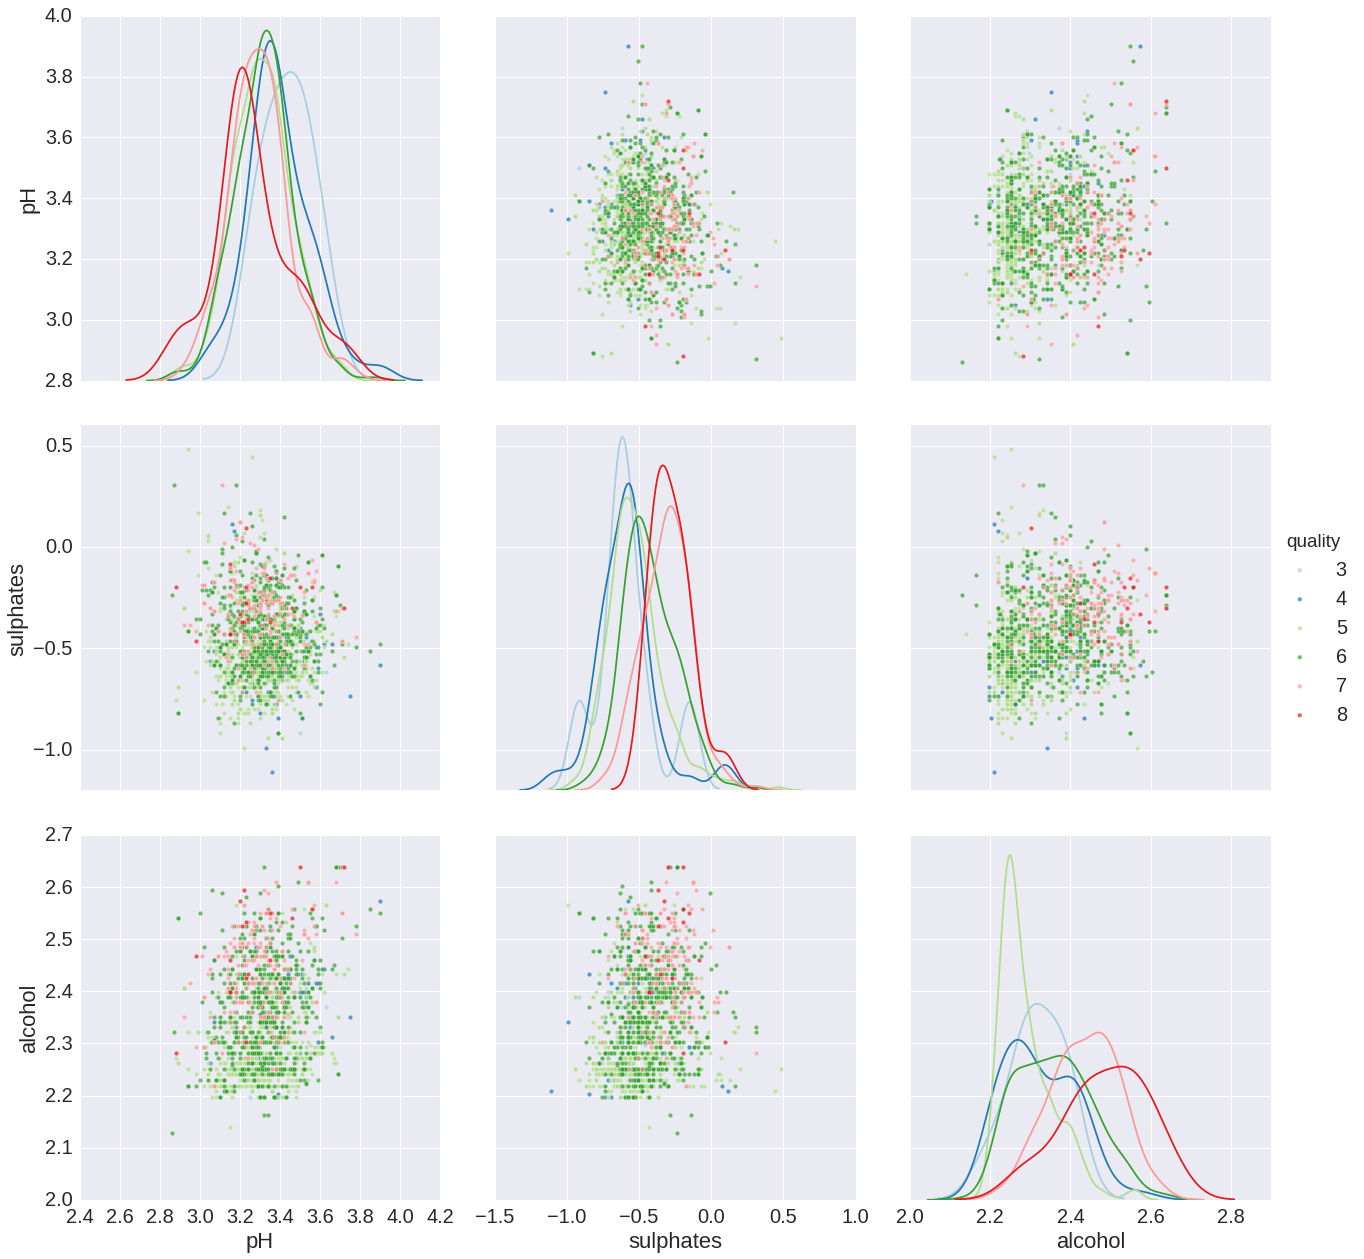

In [60]:
sns.pairplot(df_clean, vars = df_clean.columns[8:11], hue=target_name, diag_kind='kde',
            palette=sns.color_palette("Paired"), plot_kws={'hold' : True, 'marker': 'o', 'alpha': 0.7},size=6)
plt.show()

## Observations

As it is expected most attributes can separate the worst from the best wine quality

It is also noticable that most wines classified of average quality(5) have a low alcohol while on average wines of the best quality have a higher alcohol proportion

From the above we would expect that the best predictors would be: sulphates, alcohol, citric acid and volatile acidity

While the worst predictors are expected to be: chlorides and residual sugar

We will quantify their impact later to verify (or not) our observations

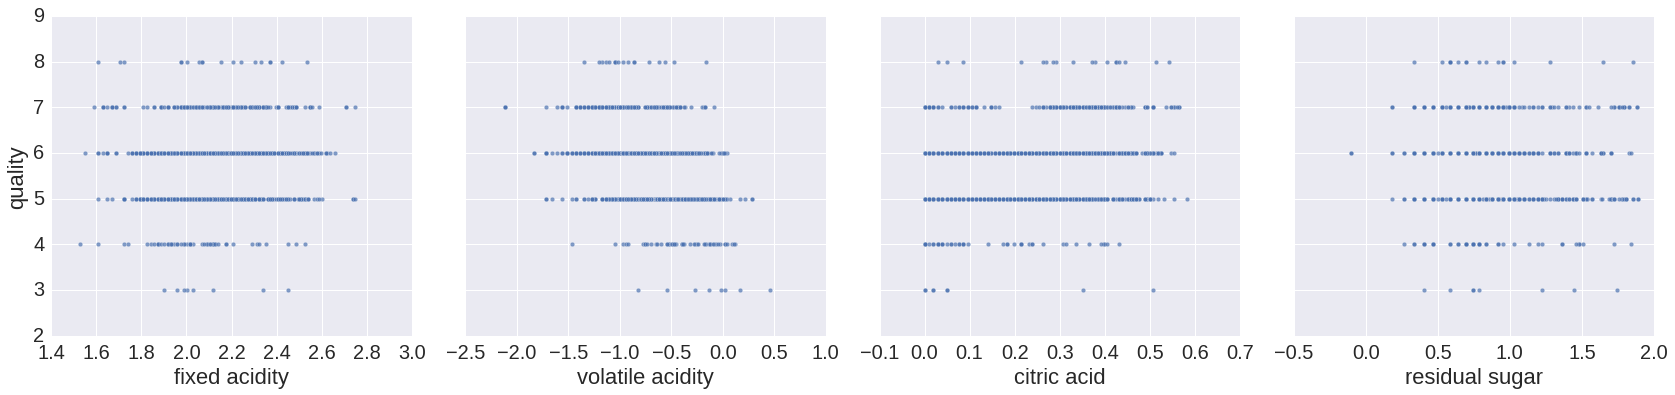

In [61]:
sns.pairplot(df_clean, x_vars = df_clean.columns[:4], y_vars=[target_name], diag_kind='kde',
            plot_kws={'hold' : True, 'marker': 'o', 'alpha': 0.7},size=6)
plt.show()

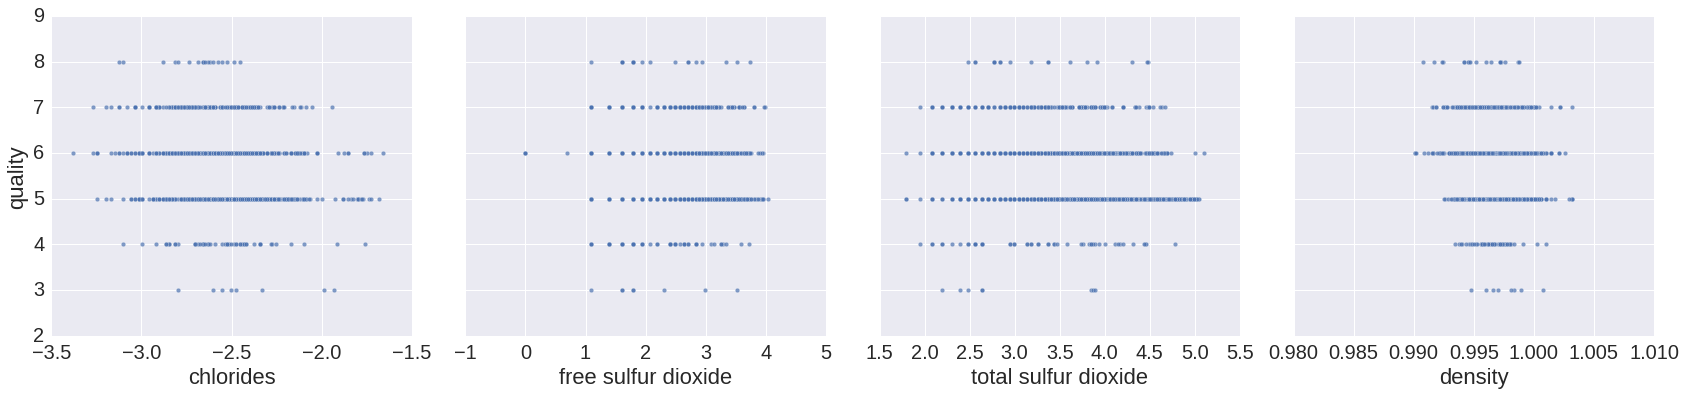

In [62]:
sns.pairplot(df_clean, x_vars = df_clean.columns[4:8], y_vars=[target_name], diag_kind='kde',
            plot_kws={'hold' : True, 'marker': 'o', 'alpha': 0.7},size=6)
plt.show()

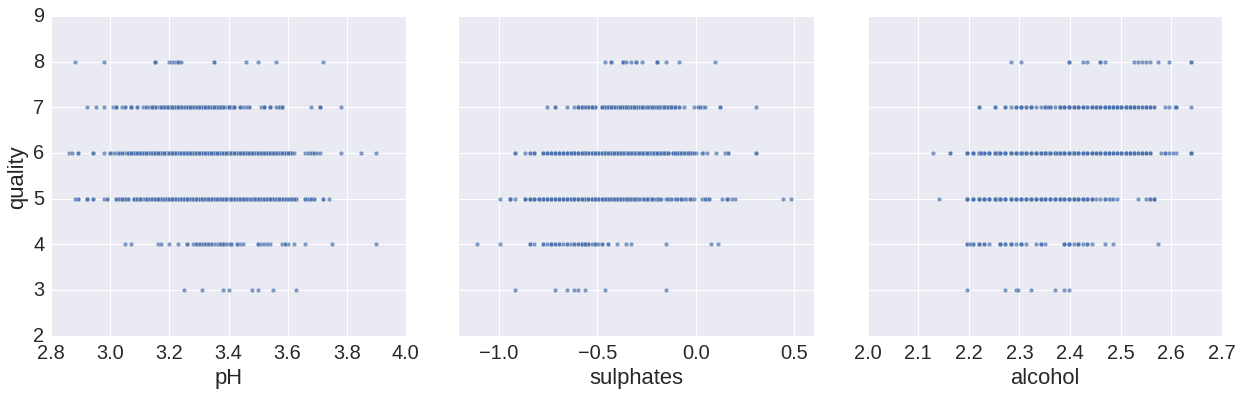

In [63]:
sns.pairplot(df_clean, x_vars = df_clean.columns[8:11], y_vars=[target_name], diag_kind='kde',
            plot_kws={'hold' : True, 'marker': 'o', 'alpha': 0.7},size=6)
plt.show()

In [72]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

In [73]:
corrs = OrderedDict([(col, pearsonr(XX_no_outliers[col], yy_no_outliers)) for col in XX_no_outliers.columns])
corrs = pd.DataFrame(index = corrs.keys(), data={
        'corr_coef': [corr[0] for corr in corrs.values()],
        'p_value': [corr[1] for corr in corrs.values()],
    })

In [74]:
corrs.applymap(lambda xx : abs(xx)).sort_values(by='corr_coef', ascending=False).rename(columns={
        'corr_coef': 'absolute correlation coefficient'
    })

,absolute correlation coefficient,p_value
alcohol,0.480277,1.191126e-88
volatile acidity,0.389662,2.307606e-56
sulphates,0.374089,9.485586e-52
citric acid,0.238494,3.980587e-21
chlorides,0.180448,1.318875e-12
total sulfur dioxide,0.173938,8.350876e-12
density,0.168068,4.156036e-11
fixed acidity,0.123273,1.409315e-06
pH,0.076604,2.785561e-03
free sulfur dioxide,0.049259,5.469211e-02


We are happy to express that pearson correlation agrees with our bare-eye observations that the strongest correlation between our features and the target value of quality are given indeed by the top four: sulphates, alcohol, citric acid and volatile acidity

Pearson correlation agrees with us that the residual sugar has almost no correlation with the quality of the red wine.
However Pearson correlation expresses that chlorides have a small correlation with the quality of the red wine, still quite small so our observation was not that bad.

Note that pearson correlation is a first indication of whether a factor that plays a weaker or stronger role to predicting the quality of the wine. We should build our classifier to quantify it better 

# Polynomial non-linear features

In [75]:
from sklearn.preprocessing import PolynomialFeatures

In [76]:
pf = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
pf

PolynomialFeatures(degree=3, include_bias=False, interaction_only=False)

In [77]:
XX_no_outliers_orig = XX_no_outliers.copy()

In [78]:
XX_no_outliers = pf.fit_transform(XX_no_outliers)
XX_no_outliers.shape

(1522, 363)

# Dimensionality reduction
Above we are observing that the bare pairplots between two attributes do not seem to provide a strong separate of the classes.  
Our alternative is going to be to use multiple techniques of bring down the dimensionality from 11 dimension to only 2 and then plot

By having all of our distributions having a bell-shaped curve we can make an assumption of gaussian distribution and normalize accordingly by subtracting the mean, to remove bias, and dividing with the standard deviation to remove scale

In [79]:
from sklearn.preprocessing import StandardScaler

In [80]:
XX_sc = StandardScaler().fit_transform(XX_no_outliers)
XX_sc.shape

(1522, 363)

In [81]:
from scatter_2d_label import scatter_2d_label

### PCA

In [83]:
from sklearn.decomposition import PCA # Import the PCA module

In [84]:
XX_pca = PCA(n_components=2, random_state=random_state).fit_transform(XX_sc)
XX_pca.shape

(1522, 2)

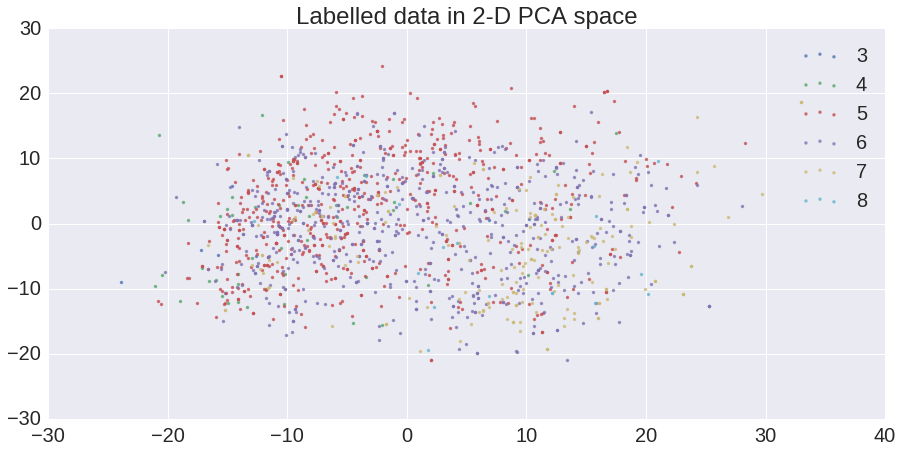

In [85]:
plt.figure(figsize=(15,7))
scatter_2d_label(XX_pca, yy_no_outliers.values, alpha=0.75)
plt.title('Labelled data in 2-D PCA space')
plt.legend(loc='best', scatterpoints=3) # Ask matplotlib to place the legend where it thinks best
plt.show()

Treating this as a classification task will be difficult because even after PCA we see that the classes are quite mixed and they do not form any apparent classes. We are going to continue building our classifier, however we might consider later to treat this like a regression task where intermediate values are allowed as well

### Isomap

In [86]:
from sklearn.manifold import Isomap

In [87]:
isomap = Isomap(n_components=2, n_neighbors=5)
XX_isomap = isomap.fit_transform(XX_sc)
XX_isomap.shape

(1522, 2)

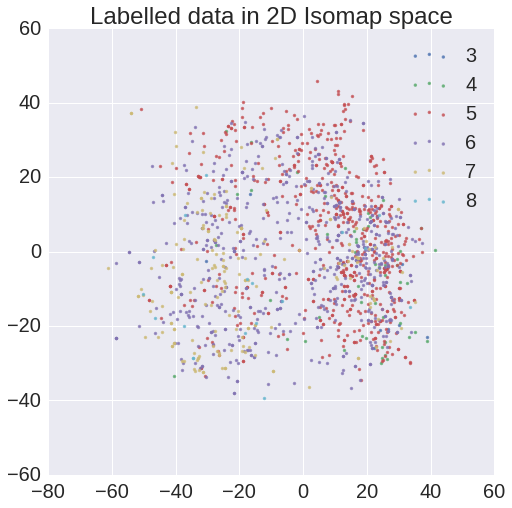

In [88]:
plt.figure(figsize=(8,8))
scatter_2d_label(XX_isomap, yy_no_outliers.values, alpha=0.75)
plt.title('Labelled data in 2D Isomap space')
plt.legend(loc='best', scatterpoints=3)
plt.show()

We see a good seperation between quality-5 and quality-7 but the rest of the classes are mixed

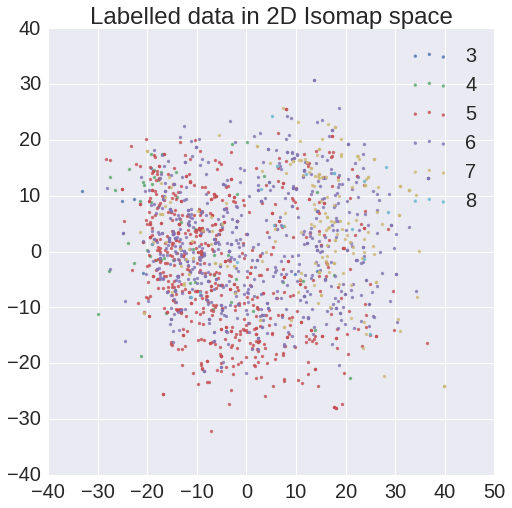

In [89]:
isomap = Isomap(n_components=2, n_neighbors=50)
XX_isomap = isomap.fit_transform(XX_sc)
plt.figure(figsize=(8,8))
scatter_2d_label(XX_isomap, yy_no_outliers.values, alpha=0.75)
plt.title('Labelled data in 2D Isomap space')
plt.legend(loc='best', scatterpoints=3)
plt.show()

### TSNE

In [90]:
from sklearn.manifold import TSNE

In [91]:
%%time
tSne = TSNE(n_components=2, perplexity=5, random_state=random_state)
XX_tsne = tSne.fit_transform(XX_sc)

CPU times: user 11.9 s, sys: 1.21 s, total: 13.1 s
Wall time: 13.1 s


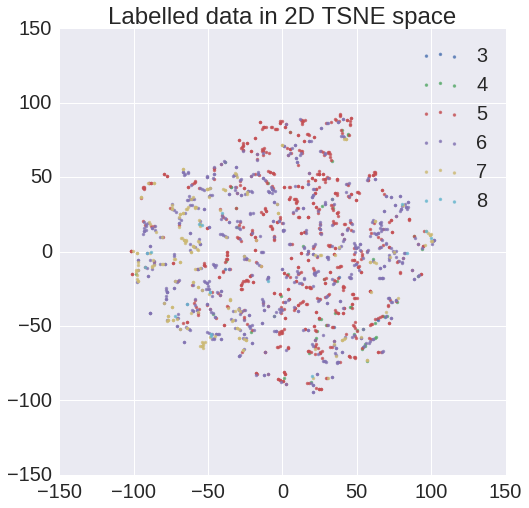

In [92]:
plt.figure(figsize=(8,8))
scatter_2d_label(XX_tsne, yy_no_outliers.values, alpha=0.75)
plt.title('Labelled data in 2D TSNE space')
plt.legend(loc='best', scatterpoints=3)
plt.show()

In [93]:
%%time
tSne = TSNE(n_components=2, perplexity=30, random_state=random_state)
XX_tsne = tSne.fit_transform(XX_sc)

CPU times: user 24.5 s, sys: 1.17 s, total: 25.7 s
Wall time: 25.7 s


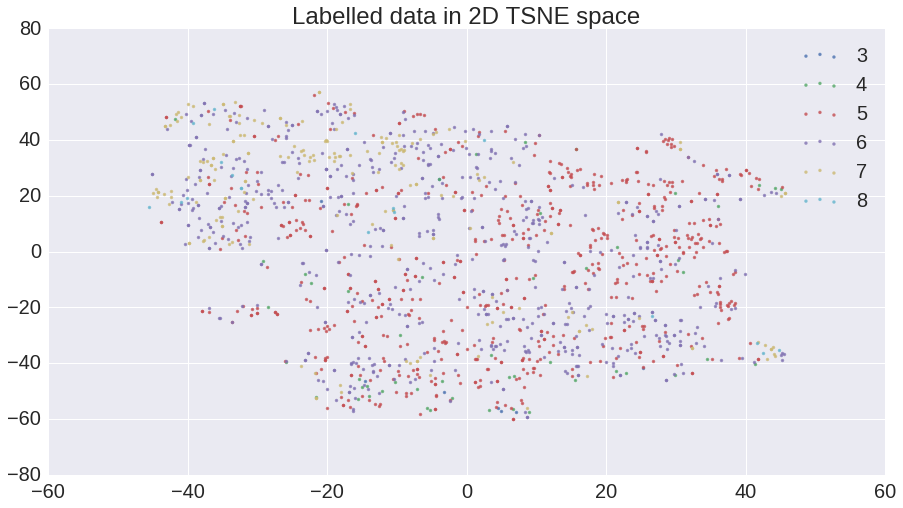

In [94]:
plt.figure(figsize=(15,8))
scatter_2d_label(XX_tsne, yy_no_outliers.values, alpha=0.75)
plt.title('Labelled data in 2D TSNE space')
plt.legend(loc='best', scatterpoints=3)
plt.show()

We see that TSNE with perplexity 30 has not been able to separate the classes but has been able to construct small neighbors where points of the same class are concentrated.

This is beneficial for algorithms such as K-neighbors classifiers that suffer from the curse of dimensionality but are able to produce complex decision boundaries

In [96]:
%%time
tSne = TSNE(n_components=3, perplexity=100, random_state=random_state)
XX_tsne = tSne.fit_transform(XX_sc)

CPU times: user 1min 52s, sys: 1.2 s, total: 1min 53s
Wall time: 1min 53s


# Train test split
We need for all the possible inputs and the targets that we are going to use to separate the ones for testing

In [97]:
#having a relatively small dataset we are going to use 90% of the inputs for training and only 10% for testing
train_fraction = 0.8
test_fraction = 1 - train_fraction
test_fraction

0.19999999999999996

In [98]:
no_outliers_len = len(XX_no_outliers)
no_outliers_len

1522

In [99]:
train_len = int(no_outliers_len * train_fraction)
test_len = no_outliers_len - train_len
train_len, test_len

(1217, 305)

In [100]:
#assumed uniform distribution per instance
# train_indices = random_state.choice(range(train_len), size=train_len, replace=False)
# assert len(np.unique(train_indices)) == train_len
# test_indices = list(set(range(no_outliers_len)).difference(train_indices))
# assert len(test_indices) == no_outliers_len - train_len

In [101]:
from sklearn.model_selection import StratifiedShuffleSplit

In [102]:
sss = StratifiedShuffleSplit(n_splits=1, random_state=random_state, test_size=test_fraction)
sss

StratifiedShuffleSplit(n_splits=1,
            random_state=<mtrand.RandomState object at 0x7fca65549820>,
            test_size=0.2, train_size=None)

In [103]:
for train_inds, test_inds in sss.split(np.zeros(len(XX_sc)), yy_no_outliers):
    train_indices = train_inds
    test_indices = test_inds
    
train_indices.shape, test_indices.shape

((1217,), (305,))

In [104]:
XX_train = XX_sc[train_indices]
XX_test = XX_sc[test_indices]
XX_train.shape, XX_test.shape

((1217, 363), (305, 363))

In [105]:
XX_lowdim_train = XX_tsne[train_indices]
XX_lowdim_test = XX_tsne[test_indices]
XX_lowdim_train.shape, XX_lowdim_test.shape

((1217, 3), (305, 3))

In [106]:
yy_train = yy_no_outliers.iloc[train_indices].values.astype(np.int)
yy_test = yy_no_outliers.iloc[test_indices].values.astype(np.int)
yy_train.shape, yy_test.shape

((1217,), (305,))

In [107]:
yy_train_percents = np.array([list(yy_train).count(cur_class) / len(yy_train) for cur_class in np.unique(yy_train)])
yy_train_percents

array([ 0.00493016,  0.0336894 ,  0.42563681,  0.39852095,  0.12571898,
        0.0115037 ])

In [108]:
yy_test_percents = np.array([list(yy_test).count(cur_class) / len(yy_test) for cur_class in np.unique(yy_test)])
yy_test_percents

array([ 0.00655738,  0.03278689,  0.42622951,  0.39672131,  0.12459016,
        0.01311475])

In [109]:
assert np.allclose(yy_train_percents, yy_test_percents, rtol=1e-2, atol=1e-2), "make sure they are almost the same"

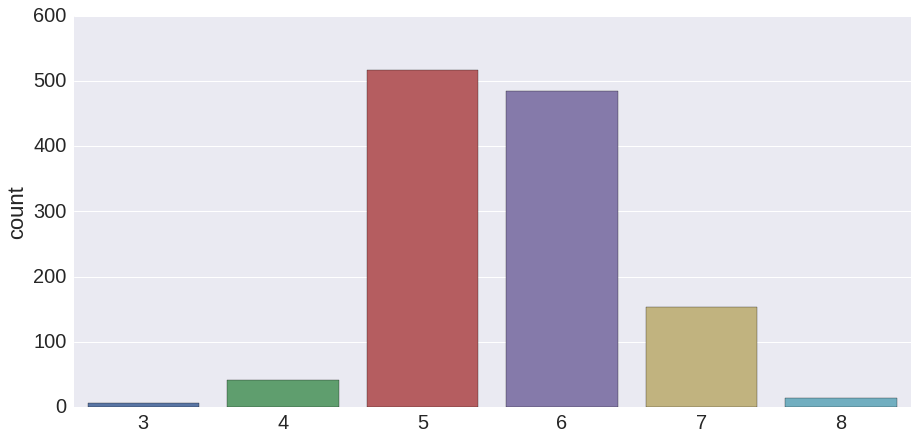

In [110]:
sns.countplot(yy_train)

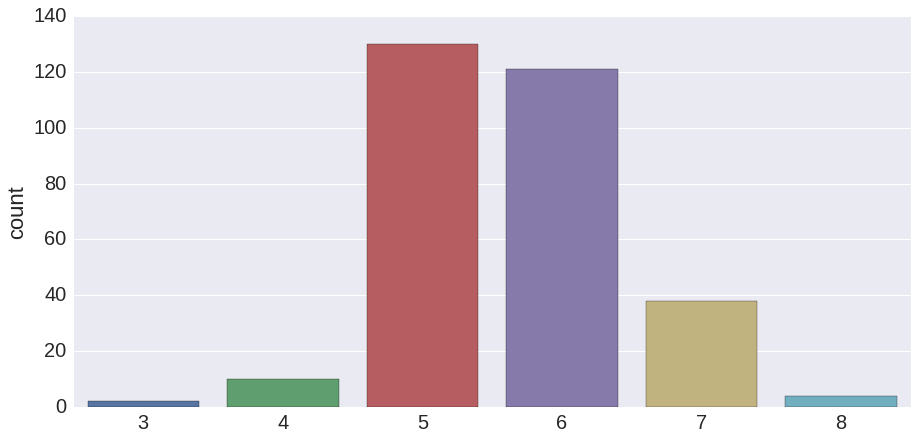

In [111]:
sns.countplot(yy_test)

# Baseline
Use the dummy classifier to set the baseline, any of our more advanced classifiers should perform better than the baseline

Note that the dummy classifier is independent to the dimensionality of the input

In [112]:
from sklearn.dummy import DummyClassifier

In [113]:
from ecdf import ecdf
from bootstrap_replicates import draw_bootstrap_replicates

In [114]:
from sklearn.metrics import f1_score

In [115]:
def score_classifier(y_true, y_pred):
    return f1_score(
        y_true, y_pred,
        average='macro', #Calculate metrics for each label, and find their unweighted mean.
        #This does not take label imbalance into account.
    )

### IMPORTANT NOTE:
Using the F1 score means that we want a classifier that takes into account all wine bottles the same.

While in a **business** case we would want to calculate precision for some bottles  
We would shift the probability threshold of classifying each class according to how much precision we would need for a particular class

In [116]:
#np.random.RandomState(seed=seed)
def dummy_classify():
    dc = DummyClassifier(random_state=random_state, strategy='stratified')
    dc.fit(XX_train, yy_train)
    #return dc.score(XX_train, yy_train), dc.score(XX_test, yy_test)
    preds = dc.predict(XX_test)
    return score_classifier(yy_test, preds)

In [117]:
%%time
dc_scores = [dummy_classify() for ii in range(10000)]

/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


CPU times: user 7.36 s, sys: 0 ns, total: 7.36 s
Wall time: 7.36 s


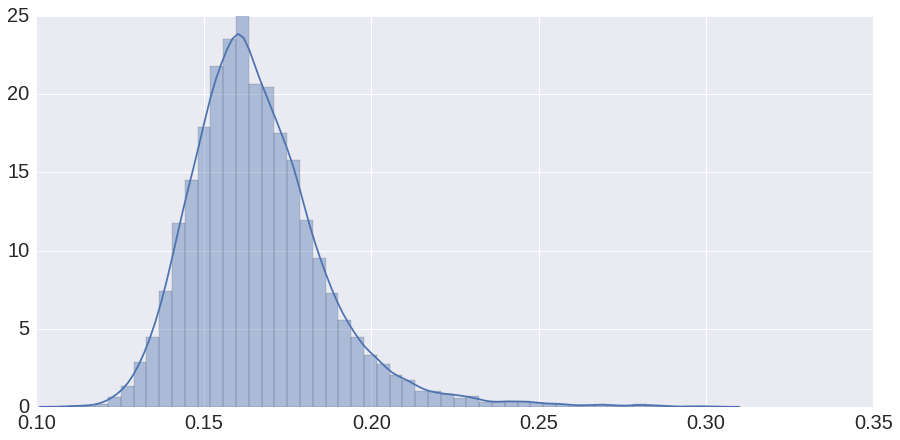

In [118]:
sns.distplot(dc_scores)
plt.show()

In [119]:
print "95% confidence interval for the f1 scores of the dummy classifier"
np.percentile(dc_scores, [2.5, 97.5])

95% confidence interval for the f1 scores of the dummy classifier


array([ 0.13431633,  0.21458792])

In other words we would want our classifiers to achieve at least **larger than ~0.21 f1 score** to consider them of being really better than our baseline!

In [356]:
dummy_classifier_best_score = 0.21

# Classification
We are going to explore multiple classifiers:

- KNN classifiers which are going to explore the lower dimensionality of our data
- SVM classifiers
- Random Forest Classifiers
- Logistic Regression Classifiers
- Quadratic Discriminant Analysis
- Naive Bayes

Use bayesian optimization to optimize each one of the above

In [173]:
available_classes = np.unique(yy)
available_classes

array([3, 4, 5, 6, 7, 8])

In [174]:
def upsample(inputs, targets):
    return ros.fit_sample(inputs, targets)

In [175]:
models = OrderedDict()

In [176]:
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical

In [177]:
from skopt.plots import plot_convergence

In [178]:
kFold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

In [179]:
def cross_validate(estimator, inputs=XX_train, targets=yy_train, upsampling=True):
    indices_iterator = kFold.split(np.zeros(len(inputs)),  # this is allowed, check documentation for more info
                                       targets)
    
    scores = []    
    for train_inds, valid_inds in indices_iterator:
        cur_xx_train = inputs[train_inds]
        cur_yy_train = targets[train_inds]
        if upsampling:
            #upsample train inds to make them balanced
            #print cur_xx_train.shape, cur_yy_train.shape
            cur_xx_train, cur_yy_train = upsample(cur_xx_train, cur_yy_train)
        
        #keep valid inds intact
        cur_xx_valid = inputs[valid_inds]
        cur_yy_valid = targets[valid_inds]
        
        estimator.fit(cur_xx_train, cur_yy_train)
        cur_preds = estimator.predict(cur_xx_valid)
        
        cur_score = score_classifier(y_true = cur_yy_valid, y_pred=cur_preds)
        scores.append(cur_score)
        
    return np.mean(scores)

## Gaussian Naive Bayes

In [214]:
from sklearn.naive_bayes import GaussianNB

In [215]:
model = GaussianNB()

In [216]:
upsampling = True

In [217]:
#priors play an important role here for the generative model, the F1 score is worse if we upsample
final_xx_train, final_yy_train = upsample(XX_train, yy_train) if upsampling else (XX_train, yy_train)
model.fit(final_xx_train, final_yy_train)

GaussianNB(priors=None)

In [218]:
preds = model.predict(XX_test)
preds.shape

(305,)

In [242]:
from plot_confusion_matrix import plot_confusion_matrix

/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/seaborn/matrix.py:134: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/seaborn/matrix.py:142: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


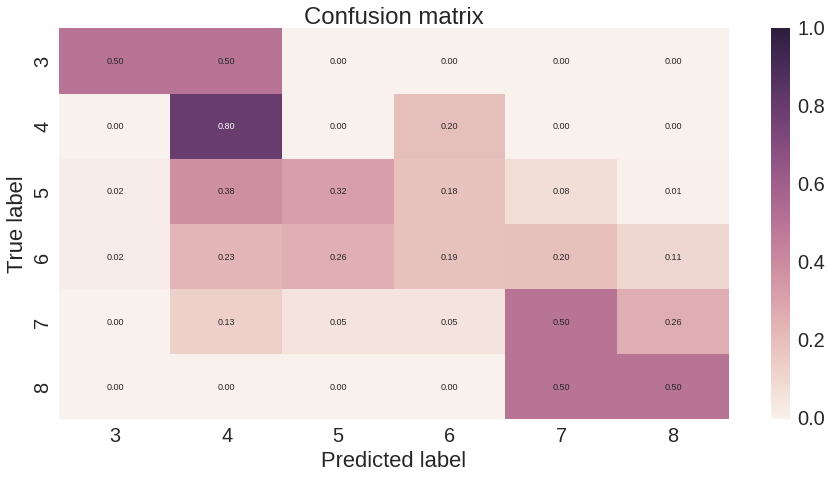

In [246]:
plot_confusion_matrix(y_true=yy_test, y_pred=preds, normalized=True, classes=available_classes)
plt.show()

In [247]:
print "score of gaussian naive bayes"
score_classifier(yy_test, preds)

score of gaussian naive bayes


0.27099936449918316

So Gaussian naive bayes achieved a better f1 score than the dummy classifier. This is a good start

In [248]:
models['naive_bayes'] = model

# Quadratic Discriminant Analysis

In [257]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [258]:
model = QuadraticDiscriminantAnalysis()

In [259]:
upsampling = True

In [260]:
#priors play an important role here for the generative model, the F1 score is worse if we upsample
final_xx_train, final_yy_train = upsample(XX_train, yy_train) if upsampling else (XX_train, yy_train)
print final_xx_train.shape, final_yy_train.shape
model.fit(final_xx_train, final_yy_train)

(3108, 363) (3108,)


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001)

In [261]:
preds = model.predict(XX_test)

In [262]:
print "score for QDA"
score_classifier(y_true=yy_test, y_pred=preds)

score for QDA


0.3063030792875206

In [263]:
models['qda'] = model

/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/seaborn/matrix.py:134: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/seaborn/matrix.py:142: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


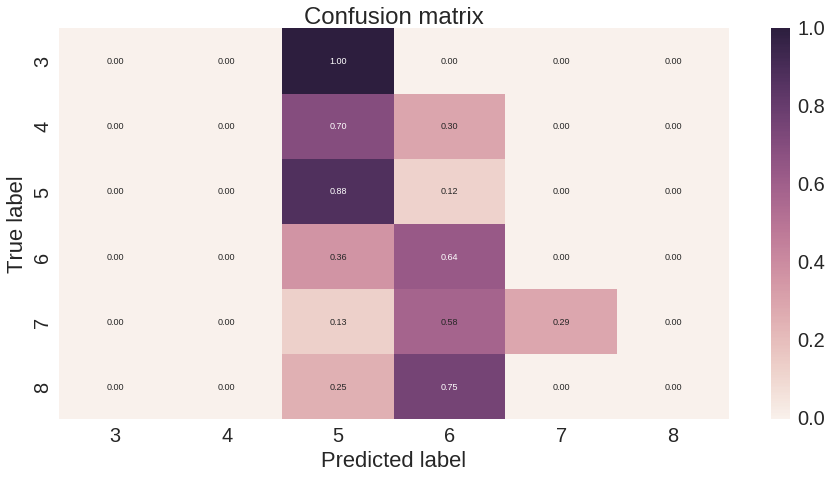

In [264]:
plot_confusion_matrix(y_true=yy_test, y_pred=preds, normalized=True, classes=available_classes)
plt.show()

## Logistic Regression

In [271]:
from sklearn.linear_model import LogisticRegression

In [272]:
upsampling = True

In [273]:
count = 0

In [274]:
def objective(params):
    C = params[0]
    
    global count
    count += 1
    print "{}) cur params: {}".format(count, params)
    
    estimator = LogisticRegression(C=C,
                                   #recall that C is inverse regularization, smaller values, stronger regularization
                                   max_iter=500, #we allow a large number of iterations since we have small dataset 
                                   solver='lbfgs', #recommended
                                  )
    
    average_score = cross_validate(estimator, upsampling=upsampling)
    
    # We want to maximise average f1 score, i.e. minimise minus f1 score
    return -average_score

In [275]:
dimensions = [
    Real(low=1e-1, high=1e5, prior='log-uniform')
]

# x0 = [1.0]

In [276]:
%%time
res_gp = gp_minimize(
    func=objective, # function that we wish to minimise
    dimensions=dimensions, #the search space for the hyper-parameters
    #x0=x0, #inital values for the hyper-parameters
    n_calls=30, #number of times the function will be evaluated
    random_state=random_state, #random seed
    n_random_starts=10,  #before we start modelling the optimised function with a GP Regression
                        #model, we want to try a few random choices for the hyper-parameters.
    #kappa=1.9 #trade-off between exploration vs. exploitation.
)

1) cur params: [1.8584214542342219]
2) cur params: [2.249109126646065]
3) cur params: [0.72740670322806722]
4) cur params: [79.790739938558019]
5) cur params: [3874.577551701303]
6) cur params: [0.52597613126465959]
7) cur params: [2.5420986966700871]
8) cur params: [24127.055557765565]
9) cur params: [76967.497171638679]
10) cur params: [1047.5312438283049]
11) cur params: [100000.0]
12) cur params: [99810.179718509855]
13) cur params: [99992.706266854031]
14) cur params: [99721.504737143041]
15) cur params: [99698.791692526065]
16) cur params: [99982.785528141845]
17) cur params: [99840.772378280031]
18) cur params: [99940.733951730974]
19) cur params: [99950.304598758972]
20) cur params: [0.10008837211675649]
21) cur params: [99470.425418885367]
22) cur params: [99997.295803921545]
23) cur params: [99938.076888181095]
24) cur params: [99992.466706946216]
25) cur params: [0.10000058425479633]
26) cur params: [0.10003977586427384]


/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


27) cur params: [100000.0]
28) cur params: [100000.0]
29) cur params: [100000.0]
30) cur params: [100000.0]
CPU times: user 1h 7min 54s, sys: 60 s, total: 1h 8min 54s
Wall time: 17min 20s


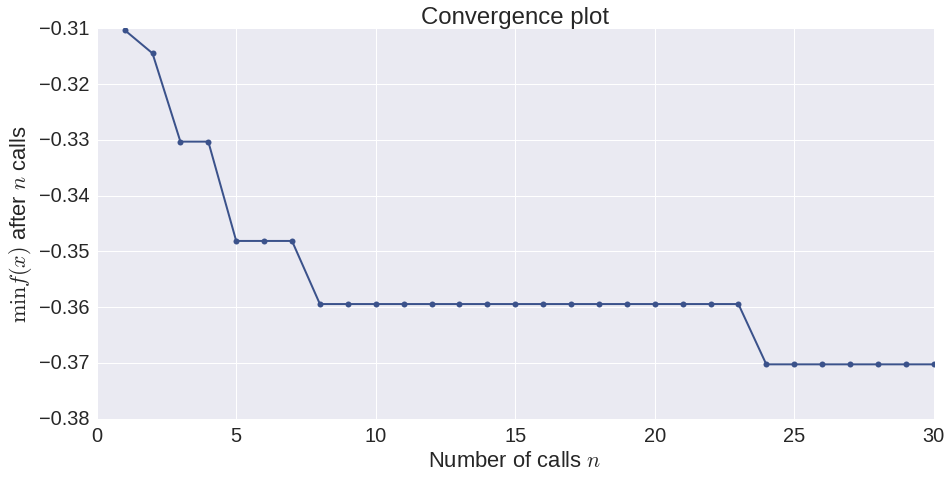

In [277]:
plot_convergence(res_gp)
plt.grid()
plt.show()

In [278]:
best_C = res_gp.x[0]
best_C

99992.466706946216

In [279]:
final_xx_train, final_yy_train = upsample(XX_train, yy_train) if upsampling else (XX_train, yy_train)
final_xx_train.shape, final_yy_train.shape

((3108, 363), (3108,))

In [280]:
model = LogisticRegression(C=best_C,
                           #recall that C is inverse regularization, smaller values, stronger regularization
                           max_iter=500, #we allow a large number of iterations since we have small dataset 
                          ).fit(final_xx_train, final_yy_train)

In [281]:
preds = model.predict(XX_test)

In [282]:
print "score for Logistic Regression"
score_classifier(y_true=yy_test, y_pred=preds)

score for Logistic Regression


0.29370122630992196

In [283]:
models['logistic_regression'] = model

/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/seaborn/matrix.py:134: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/seaborn/matrix.py:142: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


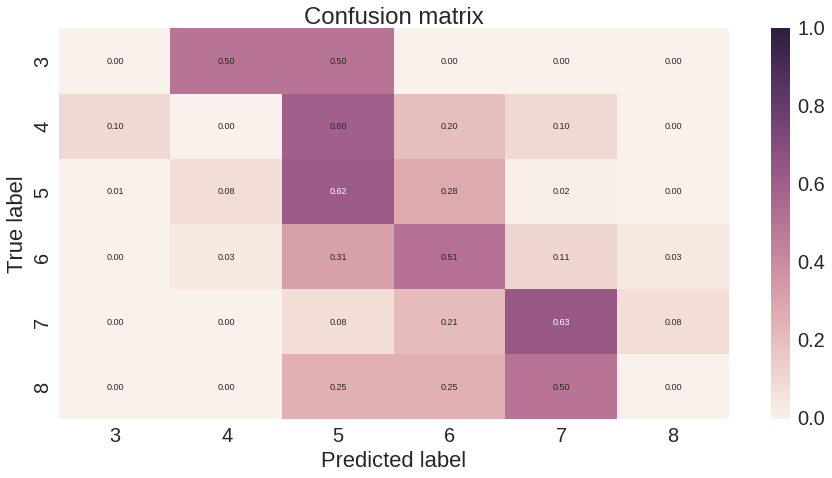

In [284]:
plot_confusion_matrix(y_true=yy_test, y_pred=preds, normalized=True, classes=available_classes)
plt.show()

## KNN classifier
Recall that for this classifier we are going to use the low dimensional space provided by TSNE transformation

In [296]:
upsampling = True

In [297]:
count = 0

In [298]:
def objective(params):
    n_neighbors = params[0]
    
    global count
    count += 1
    print "{}) cur params: {}".format(count, params)
    
    estimator = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    average_score = cross_validate(estimator, inputs=XX_lowdim_train, upsampling=upsampling)
    
    # We want to maximise average f1 score, i.e. minimise minus f1 score
    return -average_score

In [299]:
dimensions = [
    Integer(low=1, high=100)
]

#x0 = [5]

In [300]:
%%time
res_gp = gp_minimize(
    func=objective, # function that we wish to minimise
    dimensions=dimensions, #the search space for the hyper-parameters
    #x0=x0, #inital values for the hyper-parameters
    n_calls=50, #number of times the function will be evaluated
    random_state=random_state, #random seed
    n_random_starts=25,  #before we start modelling the optimised function with a GP Regression
                        #model, we want to try a few random choices for the hyper-parameters.
    #kappa=1.9 #trade-off between exploration vs. exploitation.
)

1) cur params: [22]
2) cur params: [15]
3) cur params: [2]
4) cur params: [39]
5) cur params: [29]
6) cur params: [75]
7) cur params: [30]
8) cur params: [85]
9) cur params: [33]
10) cur params: [90]
11) cur params: [27]
12) cur params: [65]
13) cur params: [19]
14) cur params: [23]
15) cur params: [81]
16) cur params: [59]
17) cur params: [19]
18) cur params: [65]
19) cur params: [74]
20) cur params: [88]
21) cur params: [94]
22) cur params: [92]
23) cur params: [53]
24) cur params: [26]
25) cur params: [48]
26) cur params: [100]
27) cur params: [100]
28) cur params: [100]
29) cur params: [100]
30) cur params: [1]
31) cur params: [100]
32) cur params: [100]
33) cur params: [100]
34) cur params: [1]
35) cur params: [100]
36) cur params: [100]
37) cur params: [100]
38) cur params: [1]
39) cur params: [1]
40) cur params: [1]
41) cur params: [100]
42) cur params: [1]
43) cur params: [100]
44) cur params: [100]
45) cur params: [1]
46) cur params: [100]
47) cur params: [1]
48) cur params: [

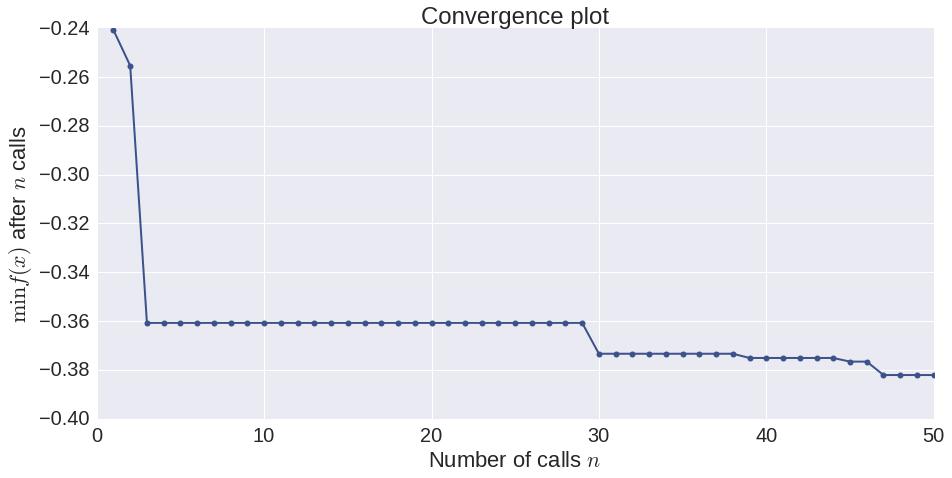

In [301]:
plot_convergence(res_gp)
plt.grid()
plt.show()

In [302]:
best_n_neighbors = res_gp.x[0]
best_n_neighbors

1

In [303]:
final_xx_train, final_yy_train = upsample(XX_lowdim_train, yy_train) if upsampling else (XX_lowdim_train, yy_train)
final_xx_train.shape, final_yy_train.shape

((3108, 3), (3108,))

In [304]:
model = KNeighborsClassifier(n_neighbors=best_n_neighbors).fit(final_xx_train, final_yy_train)

In [305]:
preds = model.predict(XX_lowdim_test)

In [306]:
print "f1 score for KNN classifier"
score_classifier(y_true=yy_test, y_pred=preds)

f1 score for KNN classifier


0.39045748052912876

In [307]:
models['knn'] = model

/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/seaborn/matrix.py:134: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/seaborn/matrix.py:142: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


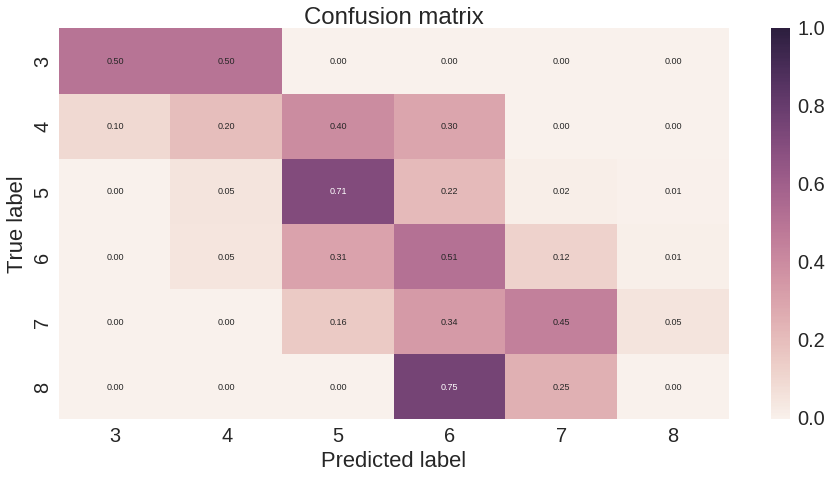

In [308]:
plot_confusion_matrix(y_true=yy_test, y_pred=preds, normalized=True, classes=available_classes)
plt.show()

# Support Vector Machine (SVM classifier)

In [309]:
from sklearn.svm import SVC

In [310]:
upsampling = True

In [311]:
count = 0

In [314]:
from time import time

In [315]:
def objective(params):
    C, kernel, degree = params
    global count
    count += 1
    
    estimator = SVC(C=C, kernel=kernel, degree=degree, probability=False) #probability not necessary here
    
    start_time = time()
    average_score = cross_validate(estimator, upsampling=upsampling)
    
    print "{}) in {} with current params: {}".format(count, time() - start_time, params)
    
    # We want to maximise average f1 score, i.e. minimise minus f1 score
    return -average_score

In [316]:
C_space = Real(low=1e-4, high=1e1, prior='log-uniform')
kernel_space = Categorical(['linear', 'poly', 'rbf', 'sigmoid'])
degree_space = Integer(low=2, high=7)

dimensions = [C_space, kernel_space, degree_space]

x0 = [1.0, 'rbf', 3]

In [317]:
%%time
res_gp = gp_minimize(
    func=objective, # function that we wish to minimise
    dimensions=dimensions, #the search space for the hyper-parameters
    x0=x0, #inital values for the hyper-parameters
    n_calls=50, #number of times the function will be evaluated
    random_state=random_state, #random seed
    n_random_starts=20,  #before we start modelling the optimised function with a GP Regression
                        #model, we want to try a few random choices for the hyper-parameters.
    #kappa=1.9 #trade-off between exploration vs. exploitation.
)

1) in 14.0931990147 with current params: [1.0, 'rbf', 3]
2) in 22.2328658104 with current params: [0.18031708117781867, 'rbf', 3]
3) in 16.9419438839 with current params: [0.43454272709146075, 'rbf', 4]
4) in 17.65498209 with current params: [0.0027707254464317847, 'linear', 5]
5) in 24.8665959835 with current params: [0.00033201031531695781, 'linear', 2]
6) in 48.2670190334 with current params: [0.0073190339323895128, 'sigmoid', 3]
7) in 51.1542189121 with current params: [0.0015982846857466454, 'rbf', 3]
8) in 39.5030112267 with current params: [0.00075108876353983511, 'poly', 6]
9) in 53.0581748486 with current params: [0.00022937323459236965, 'sigmoid', 6]
10) in 46.6448059082 with current params: [0.0093809770171081296, 'sigmoid', 4]
11) in 48.3793551922 with current params: [0.0020434859443925761, 'poly', 2]
12) in 21.5625081062 with current params: [0.20578844586152001, 'rbf', 3]
13) in 9.94774794579 with current params: [7.2775820070702304, 'rbf', 5]
14) in 51.9974269867 with c

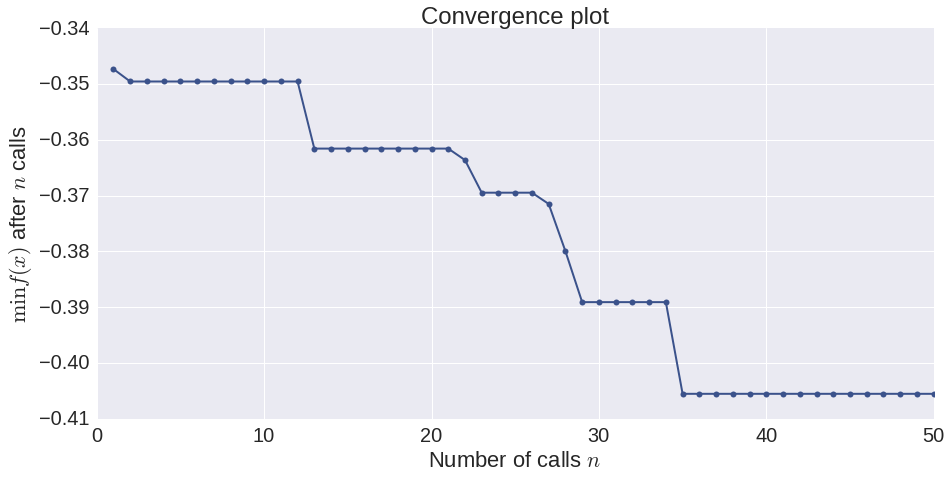

In [327]:
plot_convergence(res_gp)
plt.grid()
plt.show()

In [328]:
C, kernel, degree = res_gp.x
C, kernel, degree

(2.0486241976454074, 'linear', 2)

In [329]:
model = SVC(C=C, kernel=kernel, degree=degree, probability=True)
#probability IS necessary here because we are going to use this classifier in the ensemble voting classifier

In [321]:
final_xx_train, final_yy_train = upsample(XX_train, yy_train) if upsampling else (XX_train, yy_train)
final_xx_train.shape, final_yy_train.shape

((3108, 363), (3108,))

In [322]:
model.fit(final_xx_train, final_yy_train)

SVC(C=2.0486241976454074, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [323]:
preds = model.predict(XX_test)

In [324]:
print "score for SVC classifier"
score_classifier(y_true=yy_test, y_pred=preds)

score for SVC classifier


0.35992689177759302

In [325]:
models['svc'] = model

/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/seaborn/matrix.py:134: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/seaborn/matrix.py:142: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


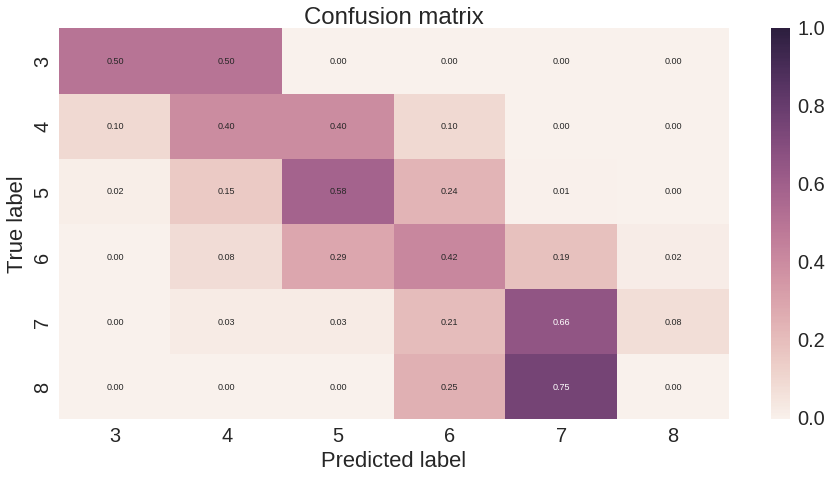

In [326]:
plot_confusion_matrix(y_true=yy_test, y_pred=preds, normalized=True, classes=available_classes)
plt.show()

# Random Forest Classifiers

In [330]:
from sklearn.ensemble import RandomForestClassifier

In [331]:
upsampling = True

In [332]:
count = 0

In [333]:
def objective(params):
    n_estimators, criterion, max_features, max_depth, min_samples_split, min_samples_leaf = params
    global count
    count += 1
    print "{}) cur params: {}".format(count, params)
    estimator = RandomForestClassifier(
        n_estimators=n_estimators, criterion=criterion, max_features=max_features, max_depth=max_depth,
        min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
    )
    
    average_score = cross_validate(estimator, upsampling=upsampling)
    
    # We want to maximise average f1 score, i.e. minimise minus f1 score
    return -average_score

In [334]:
max_feats = XX_train.shape[1]
max_feats

363

In [335]:
n_estimators = Integer(low=10, high=100)
criterion = Categorical(['gini', 'entropy'])
max_features = Integer(low=1, high=max_feats)
max_depth = Integer(low=1, high=max_feats)
min_samples_split = Integer(low=2, high=100)
min_samples_leaf = Integer(low=1, high=100)

dimensions = [n_estimators, criterion, max_features, max_depth, min_samples_split, min_samples_leaf]
#x0 = [1.0, 'rbf', 3]

In [336]:
%%time
res_gp = gp_minimize(
    func=objective, # function that we wish to minimise
    dimensions=dimensions, #the search space for the hyper-parameters
    #x0=x0, #inital values for the hyper-parameters
    n_calls=50, #number of times the function will be evaluated
    random_state=random_state, #random seed
    n_random_starts=20,  #before we start modelling the optimised function with a GP Regression
                        #model, we want to try a few random choices for the hyper-parameters.
    #kappa=1.9 #trade-off between exploration vs. exploitation.
)

1) cur params: [44, 'gini', 331, 356, 21, 100]
2) cur params: [62, 'gini', 209, 362, 66, 99]
3) cur params: [20, 'entropy', 323, 165, 79, 52]
4) cur params: [62, 'gini', 236, 191, 69, 1]
5) cur params: [41, 'gini', 184, 354, 100, 83]
6) cur params: [18, 'entropy', 301, 353, 71, 49]
7) cur params: [45, 'entropy', 62, 311, 30, 27]
8) cur params: [75, 'entropy', 99, 210, 28, 38]
9) cur params: [64, 'entropy', 174, 270, 87, 51]
10) cur params: [82, 'gini', 33, 167, 56, 12]
11) cur params: [79, 'entropy', 12, 71, 96, 49]
12) cur params: [26, 'gini', 150, 157, 47, 67]
13) cur params: [25, 'entropy', 190, 198, 11, 10]
14) cur params: [17, 'entropy', 270, 33, 48, 60]
15) cur params: [67, 'gini', 102, 206, 57, 57]
16) cur params: [17, 'gini', 54, 149, 30, 53]
17) cur params: [74, 'entropy', 343, 103, 29, 45]
18) cur params: [72, 'entropy', 116, 37, 49, 27]
19) cur params: [98, 'gini', 174, 205, 98, 10]
20) cur params: [85, 'entropy', 327, 91, 89, 48]
21) cur params: [100, 'entropy', 1, 1, 2, 1]

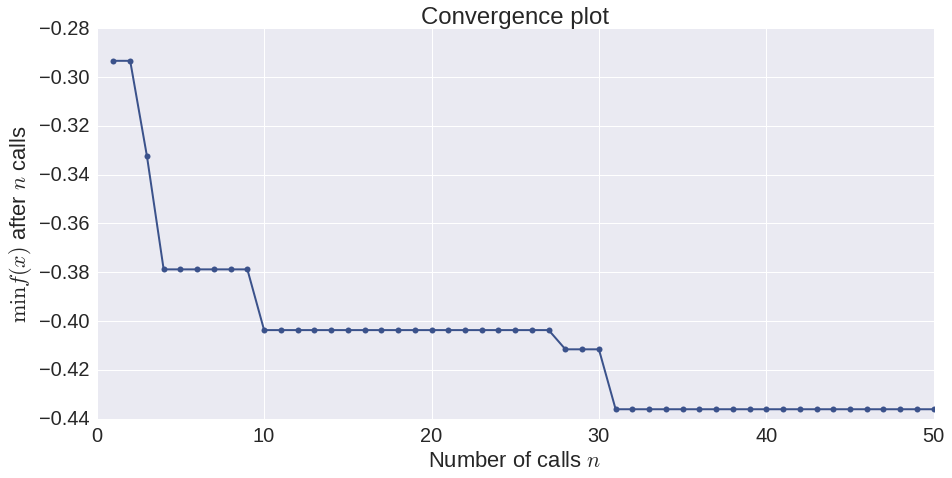

In [337]:
plot_convergence(res_gp)
plt.grid()
plt.show()

In [338]:
n_estimators, criterion, max_features, max_depth, min_samples_split, min_samples_leaf = res_gp.x
n_estimators, criterion, max_features, max_depth, min_samples_split, min_samples_leaf

(60, 'gini', 201, 363, 2, 1)

In [339]:
model = RandomForestClassifier(
        n_estimators=n_estimators, criterion=criterion, max_features=max_features, max_depth=max_depth,
        min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
    )

In [340]:
print XX_train.shape, yy_train.shape
final_xx_train, final_yy_train = upsample(XX_train, yy_train) if upsampling else (XX_train, yy_train)
final_xx_train.shape, final_yy_train.shape

(1217, 363) (1217,)


((3108, 363), (3108,))

In [341]:
model.fit(final_xx_train, final_yy_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=363, max_features=201, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [342]:
preds = model.predict(XX_test)

In [343]:
print "score for Random Forest Classifier"
score_classifier(y_true=yy_test, y_pred=preds)

score for Random Forest Classifier


0.37774086598234713

In [344]:
models['random_forest'] = model

/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/seaborn/matrix.py:134: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/seaborn/matrix.py:142: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


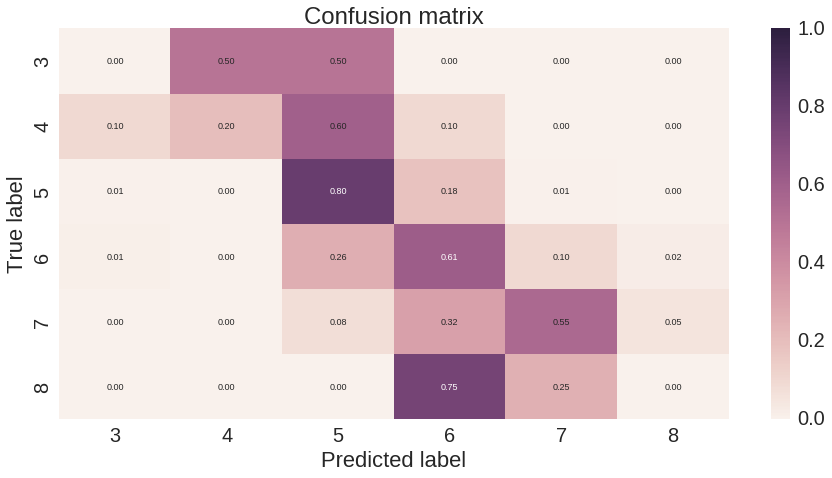

In [345]:
plot_confusion_matrix(y_true=yy_test, y_pred=preds, normalized=True, classes=available_classes)
plt.show()

# Ensemble - Voting Classifier
We are using a simple ensemble where each of the classifiers are going to vote for the final classification in order to improve the overall f1 score

In [349]:
models.keys()

['naive_bayes', 'qda', 'logistic_regression', 'knn', 'svc', 'random_forest']

In [350]:
upsampling = True

In [352]:
final_xx_train, final_yy_train = upsample(XX_train, yy_train) if upsampling else (XX_train, yy_train)
final_xx_train.shape, final_yy_train.shape

((3108, 363), (3108,))

In [353]:
final_xx_lowdim_train, final_yy_lowdim_train = upsample(XX_lowdim_train, yy_train) if upsampling else \
    (XX_lowdim_train, yy_train)
final_xx_lowdim_train.shape, final_yy_lowdim_train.shape

((3108, 3), (3108,))

In [354]:
%%time
for key, model in models.iteritems():
    print key
    inputs, targets = (final_xx_lowdim_train, final_yy_lowdim_train) if key == 'knn' else \
        (final_xx_train, final_yy_train)
    model.fit(inputs, targets)

naive_bayes
qda
logistic_regression
knn
svc
random_forest
CPU times: user 5min 12s, sys: 88 ms, total: 5min 12s
Wall time: 5min 10s


In [355]:
score_dict = OrderedDict([( key, score_classifier(
                y_true=yy_test, y_pred=model.predict(XX_lowdim_test) if key == 'knn' else model.predict(XX_test)) )
                          for (key, model) in models.iteritems()])
score_dict

OrderedDict([('naive_bayes', 0.25664521360789144),
             ('qda', 0.3063030792875206),
             ('logistic_regression', 0.29414108991983806),
             ('knn', 0.39045748052912876),
             ('svc', 0.36390815743019816),
             ('random_forest', 0.34328281120877469)])

In [359]:
assert np.all(np.array(score_dict.values()) > dummy_classifier_best_score), "you need to exclude models"

In [372]:
#my voting classifier
probas = np.zeros(shape=(len(XX_test), len(available_classes)))
for key, model in models.iteritems():
    probas += model.predict_proba(XX_lowdim_test if key == 'knn' else XX_test)

In [380]:
available_classes

array([3, 4, 5, 6, 7, 8])

In [384]:
preds = available_classes[np.argmax(probas, axis=1)]
preds.shape

(305,)

In [385]:
# from sklearn.ensemble import VotingClassifier
# vc = VotingClassifier(estimators=list(models.iteritems()), voting='soft')

In [386]:
# %%time
# vc.fit(final_xx_train, final_yy_train)

In [387]:
#preds = vc.predict(XX_test)

In [397]:
print "score of voting classifier"
score_classifier(y_true=yy_test,y_pred=preds)

score of voting classifier


0.42522948918835252

The voting classifier managed to increase the F1 score, but not substantially

In [391]:
#models['ensemble'] = vc

In [393]:
score_dict['ensemble'] = score_classifier(y_true=yy_test,y_pred=preds)

In [399]:
ensemble_preds = preds.copy()

# Comparing Models

In [394]:
score_dict.keys()

['naive_bayes',
 'qda',
 'logistic_regression',
 'knn',
 'svc',
 'random_forest',
 'ensemble']

In [395]:
df = pd.DataFrame(index=score_dict.keys(), data=score_dict.values(), columns=['score'])
df.shape

(7, 1)

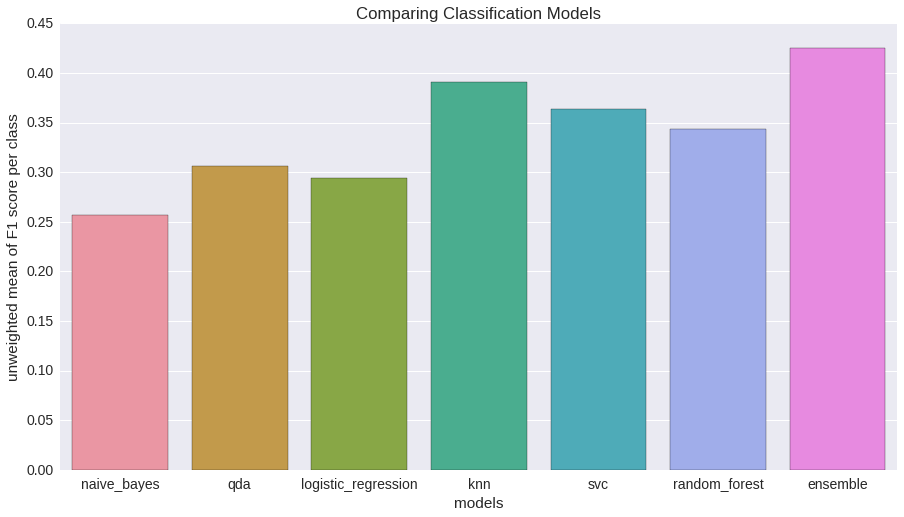

In [396]:
sns.set(font_scale=1.4)
plt.figure(figsize=(15,8))
sns.barplot(x=df.index, y=df['score'], estimator=lambda xx: xx)
plt.ylabel('unweighted mean of F1 score per class')
plt.xlabel('models')
plt.title('Comparing Classification Models')
plt.show()

# Confusion Matrix of best model

/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/seaborn/matrix.py:134: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/seaborn/matrix.py:142: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


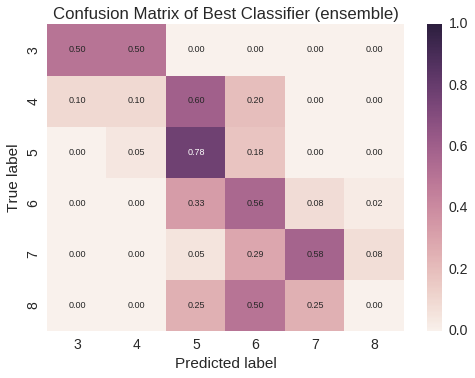

In [402]:
plot_confusion_matrix(y_true=yy_test, y_pred=ensemble_preds, normalized=True,
                      classes = available_classes, title='Confusion Matrix of Best Classifier (ensemble)')

In [403]:
from sklearn.metrics import classification_report

In [405]:
print classification_report(y_true=yy_test, y_pred=ensemble_preds)

             precision    recall  f1-score   support

          3       0.50      0.50      0.50         2
          4       0.12      0.10      0.11        10
          5       0.67      0.78      0.72       130
          6       0.64      0.56      0.60       121
          7       0.67      0.58      0.62        38
          8       0.00      0.00      0.00         4

avg / total       0.63      0.63      0.63       305



# Most important Features

In [418]:
from sklearn.ensemble import RandomForestClassifier

In [419]:
upsampling = True

In [420]:
count = 0

In [421]:
XX_no_outliers_orig.columns

Index([u'fixed acidity', u'volatile acidity', u'citric acid',
       u'residual sugar', u'chlorides', u'free sulfur dioxide',
       u'total sulfur dioxide', u'density', u'pH', u'sulphates', u'alcohol'],
      dtype='object')

In [426]:
def objective(params):
    n_estimators, criterion, max_features, max_depth, min_samples_split, min_samples_leaf = params
    global count
    count += 1
    print "{}) cur params: {}".format(count, params)
    estimator = RandomForestClassifier(
        n_estimators=n_estimators, criterion=criterion, max_features=max_features, max_depth=max_depth,
        min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
    )
    
    average_score = cross_validate(estimator, inputs=XX_no_outliers_orig.values, targets=yy_no_outliers.values,
                                   upsampling=upsampling)
    
    # We want to maximise average f1 score, i.e. minimise minus f1 score
    return -average_score

In [427]:
max_feats = XX_no_outliers_orig.shape[1]
max_feats

11

In [428]:
n_estimators = Integer(low=10, high=100)
criterion = Categorical(['gini', 'entropy'])
max_features = Integer(low=1, high=max_feats)
max_depth = Integer(low=1, high=max_feats)
min_samples_split = Integer(low=2, high=100)
min_samples_leaf = Integer(low=1, high=100)

dimensions = [n_estimators, criterion, max_features, max_depth, min_samples_split, min_samples_leaf]
#x0 = [1.0, 'rbf', 3]

In [429]:
%%time
res_gp = gp_minimize(
    func=objective, # function that we wish to minimise
    dimensions=dimensions, #the search space for the hyper-parameters
    #x0=x0, #inital values for the hyper-parameters
    n_calls=50, #number of times the function will be evaluated
    random_state=random_state, #random seed
    n_random_starts=20,  #before we start modelling the optimised function with a GP Regression
                        #model, we want to try a few random choices for the hyper-parameters.
    #kappa=1.9 #trade-off between exploration vs. exploitation.
)

2) cur params: [34, 'entropy', 3, 1, 68, 10]
3) cur params: [54, 'gini', 7, 10, 34, 9]
4) cur params: [29, 'gini', 7, 10, 18, 76]
5) cur params: [82, 'gini', 3, 4, 60, 34]
6) cur params: [25, 'gini', 4, 8, 51, 78]
7) cur params: [79, 'gini', 11, 8, 32, 22]
8) cur params: [30, 'entropy', 4, 3, 98, 72]
9) cur params: [22, 'entropy', 10, 8, 51, 83]
10) cur params: [45, 'entropy', 10, 6, 19, 47]
11) cur params: [62, 'gini', 8, 6, 98, 97]
12) cur params: [81, 'entropy', 3, 2, 37, 12]
13) cur params: [57, 'entropy', 4, 6, 43, 45]
14) cur params: [70, 'gini', 8, 6, 72, 46]
15) cur params: [60, 'entropy', 9, 3, 24, 15]
16) cur params: [63, 'entropy', 9, 2, 64, 45]
17) cur params: [58, 'entropy', 8, 7, 33, 86]
18) cur params: [73, 'gini', 8, 11, 13, 58]
19) cur params: [46, 'gini', 11, 3, 16, 39]
20) cur params: [19, 'gini', 9, 7, 70, 44]
21) cur params: [94, 'entropy', 10, 11, 53, 71]
22) cur params: [10, 'gini', 1, 11, 2, 100]
23) cur params: [100, 'gini', 1, 11, 2, 1]
24) cur params: [100, '

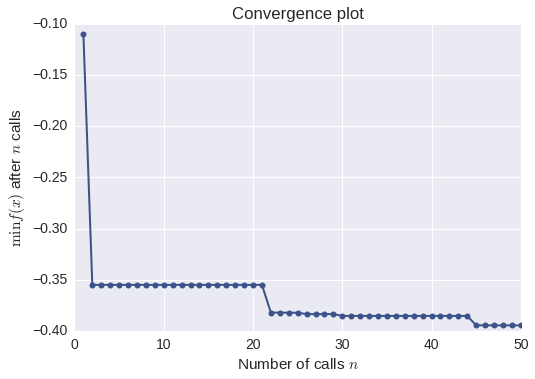

In [430]:
plot_convergence(res_gp)
plt.grid()
plt.show()

In [431]:
n_estimators, criterion, max_features, max_depth, min_samples_split, min_samples_leaf = res_gp.x
n_estimators, criterion, max_features, max_depth, min_samples_split, min_samples_leaf

(100, 'entropy', 1, 11, 2, 1)

In [432]:
model = RandomForestClassifier(
        n_estimators=n_estimators, criterion=criterion, max_features=max_features, max_depth=max_depth,
        min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
    )

In [433]:
model.fit(XX_no_outliers_orig, yy_no_outliers)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=11, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [441]:
feats_imps = OrderedDict(zip(XX_no_outliers_orig.columns, model.feature_importances_))
feats_imps = pd.DataFrame(index=feats_imps.keys(), data=feats_imps.values(),
                          columns=['feature_importance']).sort_values(by='feature_importance', ascending=False)
feats_imps

,feature_importance
alcohol,0.135047
sulphates,0.110737
volatile acidity,0.099705
total sulfur dioxide,0.096460
density,0.090399
citric acid,0.086394
fixed acidity,0.080371
chlorides,0.078501
pH,0.077418
residual sugar,0.073119


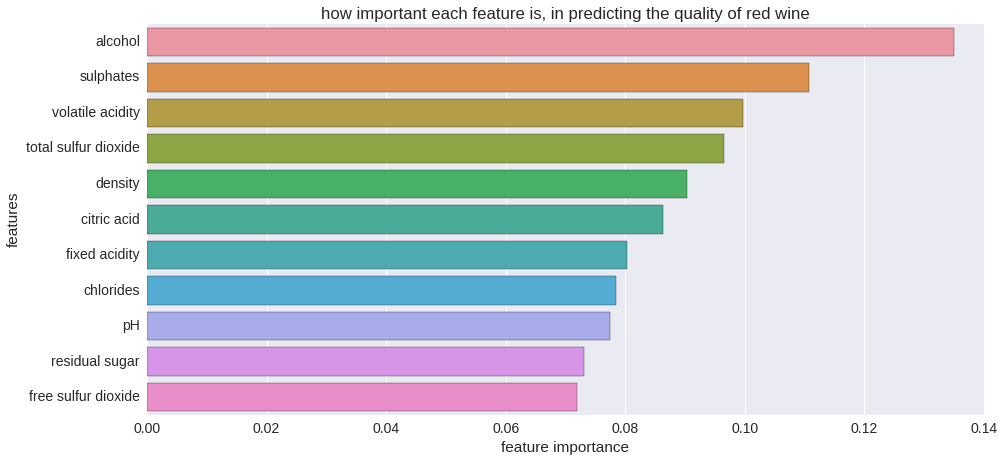

In [447]:
plt.figure(figsize=(15,7))
sns.barplot(y=feats_imps.index, x=feats_imps['feature_importance'])
plt.xlabel('feature importance')
plt.ylabel('features')
plt.title('how important each feature is, in predicting the quality of red wine')
plt.show()